# Time delay-cosmography with uncertain PSF

This notebook requires standard python libraries and the publicly available packages on github:

- lenstronomy (https://github.com/sibirrer/lenstronomy)
- fastell4py (https://github.com/sibirrer/fastell4py), based on the original fastell fortran code (by Barkana)
- STARRED (https://gitlab.com/cosmograil/starred), based on the method described in https://ui.adsabs.harvard.edu/abs/2024arXiv240208725M/abstract


WARNING: a proper installation of fastell4py needs a fortran compiler. 


This notebook is an extension of [this notebook](https://github.com/lenstronomy/lenstronomy-tutorials/blob/main/Notebooks/TimeDelayCosmography/time_delay_cosmography_with_uncertain_psf.ipynb), using STARRED instead of the lenstronomy build-in PSF iteration procedure. 
STARRED offers to main advantages: 


- it leverages the sub-pixel PSF information contained in the 4 quasar images, that are projected with different sub-pixel shift on the pixel grid. In other word, STARRED is reconstructing a drizzled version of the PSF, which allows us to reconstruct features of the PSF that are not sampled at the original pixel scale. For this reason, __we highly recommend to use__ `point_source_supersampling_factor = 3`. Choosing a even `point_source_supersampling_factor` will result in some inconsistency between the STARRED and lenstronomy PSF centering convention.


- STARRED uses a sparse regularisation procedure, that has also the effect of denoising the reconstructed PSF. You can choose the "intensity" of the denoising by changing 'lambda_scales' and 'lambda_hf'. 'lambda_scales = lambda_hf = 3' means that only the feature that are 3$\sigma$ above the noise level will be reconstructed in the PSF. __We recommend to use__ '2 < lambda_scales = lambda_hf < 3' for optimal reconstruction.

Note that STARRED runs perfectly fine on CPU but it is much faster on GPU. You'll need a GPU compatible JAX installation for that. See the [STARRED documentation](https://cosmograil.gitlab.io/starred/installation.html) for more detail.

The key parameters to adjust the behavior of STARRED are passed through 'kwargs_psf_iter`. Here is a minimal example:

```
kwargs_psf_iter = { 
                'keep_psf_error_map': True, 
                'num_iter': 1, #we will just run STARRED once, you might want to run it more than once (3 is a good number for a first reconstruction)
                'psf_iter_factor': 1, # we will fully update the PSF (recommended)
                'kwargs_starred': {'verbose':True, 'lambda_scales':3, 'lambda_hf':3}, #Choose regularisation parameters here
                'use_starred': True, 
                } 
```
Other options can be passed to control the behavior of the optimiser. Keyword arguments contained in `kwargs_starred` are passed to this [STARRED function](https://gitlab.com/cosmograil/starred/-/blob/main/starred/procedures/psf_routines.py?ref_type=heads#L225).

Finally, If you make use of the STARRED PSF fitting algorithm, we recommend acknowledging the papers listed [here](https://cosmograil.gitlab.io/starred/citing.html). 

For further information, please get in touch with the author of this notebook, Simon Birrer: sibirrer@gmail.com and Martin Millon: martin.millon@hotmail.fr for the STARRED part

In [1]:
# import of standard python libraries
import numpy as np
import os
import time
import corner
import astropy.io.fits as pyfits

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

# make sure lenstronomy is installed, otherwise install the latest pip version
try:
    import lenstronomy
except:
    !pip install lenstronomy

try:
    import starred
except:
    !pip install starred-astro

# lenstronomy imports
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.ImSim.image_model import ImageModel
import lenstronomy.Util.param_util as param_util
import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
from lenstronomy.Util import kernel_util
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
import dill as pkl

## simulation choices

/var/folders/k5/9nxb2fnj4zsbb1nrtpvbf8000000gn/T/ipykernel_59288/2869137786.py:18: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  kernel_blurred = ndimage.filters.gaussian_filter(kernel, 0.5, mode='nearest', truncate=5)


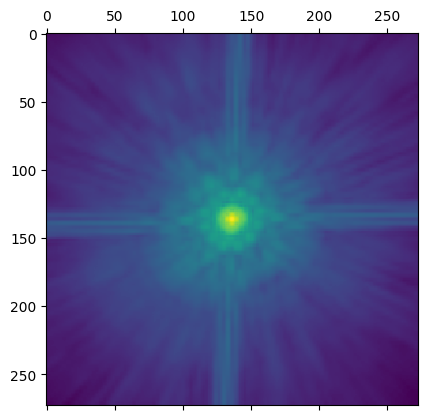

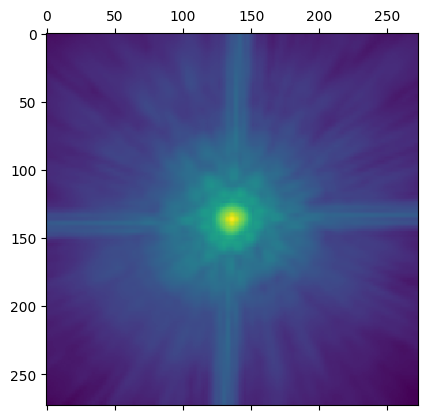

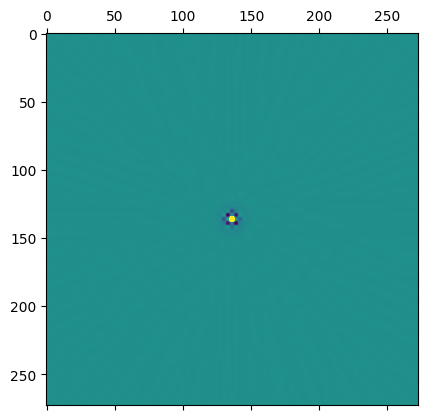

In [2]:

# define lens configuration and cosmology (not for lens modelling)
z_lens = 0.5
z_source = 1.5
point_source_supersampling_factor = 3
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.)


# import PSF file
path = os.getcwd()
dirpath, _ = os.path.split(path)
module_path, _ = os.path.split(dirpath)
psf_filename = os.path.join(module_path, 'Data/PSF_TinyTim/psf_example.fits')
kernel = pyfits.getdata(psf_filename)

# blurr the PSF, this will be our starting point estimate
import scipy.ndimage as ndimage
kernel_blurred = ndimage.filters.gaussian_filter(kernel, 0.5, mode='nearest', truncate=5)
    
# data specifics
sigma_bkg = .05  #  background noise per pixel (Gaussian)
exp_time = 100.  #  exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 100  #  cutout pixel size
deltaPix = 0.05#  pixel size in arcsec (area per pixel = deltaPix**2)
psf_type = 'PIXEL'  # 'gaussian', 'pixel', 'NONE'
kernel_size = 91

# initial input simulation

# generate the coordinate grid and image properties
kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, sigma_bkg)
data_class = ImageData(**kwargs_data)
# generate the psf variables
kernel_cut = kernel_util.cut_psf(kernel, kernel_size)

# we will provide a subsampled version of the PSF kernel to the PSF class, this is required as STARRED works much better with a subsampled PSF.
# This has to be set at the initialisation of the PSF class, the psf_iteration routines can not update that during the fit at the momment. 
if point_source_supersampling_factor > 1:
    kernel_cut = kernel_util.subgrid_kernel(kernel_cut, subgrid_res=point_source_supersampling_factor, odd=True, num_iter=100)

kwargs_psf_true = {'psf_type': psf_type, 'pixel_size': deltaPix, 'kernel_point_source': kernel_cut,
                   'point_source_supersampling_factor': point_source_supersampling_factor}

kernel_cut_blurred = kernel_util.cut_psf(kernel_blurred, kernel_size)
if point_source_supersampling_factor > 1:
    kernel_cut_blurred = kernel_util.subgrid_kernel(kernel_cut_blurred, subgrid_res=point_source_supersampling_factor, odd=True, num_iter=100)

kwargs_psf = {'psf_type': psf_type, 'pixel_size': deltaPix, 'kernel_point_source': kernel_cut_blurred, 
              'point_source_supersampling_factor': point_source_supersampling_factor}
psf_class_true = PSF(**kwargs_psf_true)
psf_class = PSF(**kwargs_psf)


plt.matshow(np.log10(kernel_cut))
plt.show()

plt.matshow(np.log10(kernel_cut_blurred))
plt.show()

plt.matshow(kernel_cut - kernel_cut_blurred, vmin=-0.001, vmax=0.001)
plt.show()


/var/folders/k5/9nxb2fnj4zsbb1nrtpvbf8000000gn/T/ipykernel_59288/3022968953.py:78: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(image_sim), origin='lower', vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 1, 0, 1])


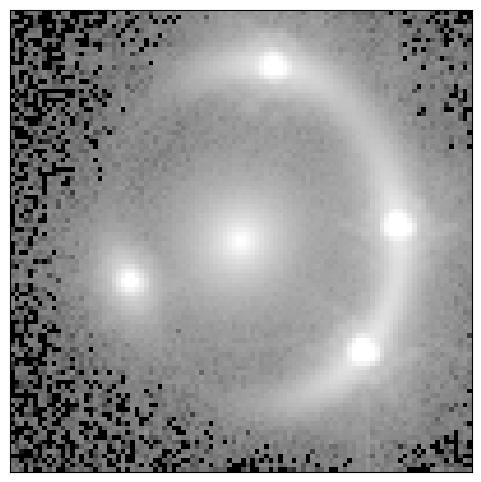

In [3]:
# lensing quantities
gamma1, gamma2 = param_util.shear_polar2cartesian(phi=-np.pi/2, gamma=0.05)
kwargs_shear = {'gamma1': gamma1, 'gamma2': gamma2}  # shear values
kwargs_pemd = {'theta_E': 1.66, 'gamma': 1.95, 'center_x': 0.0, 'center_y': 0, 'e1': 0.1, 'e2': 0.1}  # parameters of the deflector lens model

# the lens model is a supperposition of an elliptical lens model with external shear
lens_model_list = ['EPL', 'SHEAR']
kwargs_lens = [kwargs_pemd, kwargs_shear]
lens_model_class = LensModel(lens_model_list=lens_model_list, z_lens=z_lens, z_source=z_source, cosmo=cosmo)

# choice of source type
source_type = 'SERSIC'  # 'SERSIC' or 'SHAPELETS'

source_x = 0.2
source_y = 0.1


# Sersic parameters in the initial simulation
phi_G, q = 0.5, 0.8
e1, e2 = param_util.phi_q2_ellipticity(phi_G, q)
kwargs_sersic_source = {'amp': 4000, 'R_sersic': 0.1, 'n_sersic': 1, 'e1': e1, 'e2': e2, 'center_x': source_x, 'center_y': source_y}
#kwargs_else = {'sourcePos_x': source_x, 'sourcePos_y': source_y, 'quasar_amp': 400., 'gamma1_foreground': 0.0, 'gamma2_foreground':-0.0}
source_model_list = ['SERSIC_ELLIPSE']
kwargs_source = [kwargs_sersic_source]
source_model_class = LightModel(light_model_list=source_model_list)


# lens light model
phi_G, q = 0.9, 0.9
e1, e2 = param_util.phi_q2_ellipticity(phi_G, q)
kwargs_sersic_lens = {'amp': 8000, 'R_sersic': 0.2, 'n_sersic': 2., 'e1': e1, 'e2': e2, 'center_x': 0.0, 'center_y': 0}
lens_light_model_list = ['SERSIC_ELLIPSE']
kwargs_lens_light = [kwargs_sersic_lens]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)

lensEquationSolver = LensEquationSolver(lens_model_class)
x_image, y_image = lensEquationSolver.findBrightImage(source_x, source_y, kwargs_lens, numImages=4,
                                                      min_distance=deltaPix, search_window=numPix * deltaPix)
mag = lens_model_class.magnification(x_image, y_image, kwargs=kwargs_lens)
kwargs_ps = [{'ra_image': x_image, 'dec_image': y_image,
                           'point_amp': np.abs(mag)*1000}]  # quasar point source position in the source plane and intrinsic brightness
point_source_list = ['LENSED_POSITION']
point_source_class = PointSource(point_source_type_list=point_source_list, fixed_magnification_list=[False])

kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False,
                  'point_source_supersampling_factor': point_source_supersampling_factor}

imageModel = ImageModel(data_class, psf_class_true, lens_model_class, source_model_class,
                                lens_light_model_class,
                                point_source_class, kwargs_numerics=kwargs_numerics)

# generate image
image_sim = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_ps)
poisson = image_util.add_poisson(image_sim, exp_time=exp_time)
bkg = image_util.add_background(image_sim, sigma_bkd=sigma_bkg)
image_sim = image_sim + bkg + poisson
data_class.update_data(image_sim)
kwargs_data['image_data'] = image_sim


kwargs_model = {'lens_model_list': lens_model_list, 
                 'lens_light_model_list': lens_light_model_list,
                 'source_light_model_list': source_model_list,
                'point_source_model_list': point_source_list
                 }

# display the initial simulated image
cmap_string = 'gray'
cmap = plt.get_cmap(cmap_string)
cmap.set_bad(color='k', alpha=1.)
cmap.set_under('k')

v_min = -4
v_max = 2

f, axes = plt.subplots(1, 1, figsize=(6, 6), sharex=False, sharey=False)
ax = axes
im = ax.matshow(np.log10(image_sim), origin='lower', vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 1, 0, 1])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)
plt.show()

## time delays
time delays are defined in **lenstronomy** as the difference in light travel path relative to a straight line. Negative values correspond to earlier arrival times. The units are in days.

In [4]:
# time delays, the unit [days] is matched when the lensing angles are in arcsec

from lenstronomy.Analysis.td_cosmography import TDCosmography
td_cosmo = TDCosmography(z_lens, z_source, kwargs_model, cosmo_fiducial=cosmo)

# time delays, the unit [days] is matched when the lensing angles are in arcsec
t_days = td_cosmo.time_delays(kwargs_lens, kwargs_ps, kappa_ext=0)
print("the time delays for the images at position ", kwargs_ps[0]['ra_image'], kwargs_ps[0]['dec_image'], "are: ", t_days)

# relative delays (observable). The convention is relative to the first image
dt_days =  t_days[1:] - t_days[0]
# and errors can be assigned to the measured relative delays (full covariance matrix not yet implemented)
dt_sigma = [3, 5, 2]  # Gaussian errors
# and here a realisation of the measurement with the quoted error bars
dt_measured = np.random.normal(dt_days, dt_sigma)
print("the measured relative delays are: ", dt_measured)

the time delays for the images at position  [ 0.35302851  1.32507501  1.69993942 -1.1973414 ] [ 1.8915277  -1.19417343  0.16522287 -0.43528866] are:  [-147.69894773 -133.21139497 -128.32128449  -67.49330428]
the measured relative delays are:  [12.04979704 20.66437946 78.15738225]


## Model and parameter choices

In [5]:
# lens model choicers
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

fixed_lens.append({}) 
kwargs_lens_init.append({'theta_E': 1.5, 'gamma': 2, 'center_x': 0.0, 'center_y': 0, 'e1': 0, 'e2': 0.})
#kwargs_lens_init.append(kwargs_spemd)
kwargs_lens_sigma.append({'theta_E': .1, 'e1': 0.1, 'e2': 0.1, 'gamma': 0.1, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_lens.append({'theta_E': 0.01,'q': .5, 'gamma': 1.5, 'phi_G': 0., 'center_x': -10, 'center_y': -10})
kwargs_upper_lens.append({'theta_E': 10,'q': .5, 'gamma': 2.5, 'phi_G': 0., 'center_x': 10, 'center_y': 10})

fixed_lens.append({'ra_0': 0, 'dec_0': 0})
kwargs_lens_init.append({'gamma1': 0, 'gamma2': 0})
#kwargs_lens_init.append(kwargs_shear)
kwargs_lens_sigma.append({'gamma1': 0.1, 'gamma2': 0.1})
kwargs_lower_lens.append({'gamma1': -0.5, 'gamma2': -0.5})
kwargs_upper_lens.append({'gamma1': 0.5, 'gamma2': 0.5})

lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens, kwargs_lower_lens, kwargs_upper_lens]

# lens light model choices
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

fixed_lens_light.append({})
kwargs_lens_light_init.append({'R_sersic': 0.5, 'n_sersic': 1, 'e1': 0, 'e2': 0., 'center_x': 0, 'center_y': 0})
#kwargs_lens_light_init.append(kwargs_sersic_lens)
kwargs_lens_light_sigma.append({'n_sersic': 0.5, 'R_sersic': 0.1, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_lens_light.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.01, 'n_sersic': 0.5, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens_light.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 8, 'center_x': 10, 'center_y': 10})

lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, fixed_lens_light, kwargs_lower_lens_light, kwargs_upper_lens_light]


fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

fixed_source.append({})
kwargs_source_init.append({'R_sersic': 0.1, 'n_sersic': 1, 'e1': 0, 'e2': 0., 'center_x': 0, 'center_y': 0})
#kwargs_source_init.append(kwargs_sersic_source)
kwargs_source_sigma.append({'n_sersic': 0.5, 'R_sersic': 0.05, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_source.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.001, 'n_sersic': .5, 'center_x': -10, 'center_y': -10})
kwargs_upper_source.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 5., 'center_x': 10, 'center_y': 10})

source_params = [kwargs_source_init, kwargs_source_sigma, fixed_source, kwargs_lower_source, kwargs_upper_source]


fixed_ps = [{}]
kwargs_ps_init = kwargs_ps
kwargs_ps_sigma = [{'ra_image': 0.01 * np.ones(len(x_image)), 'dec_image': 0.01 * np.ones(len(x_image))}]
kwargs_lower_ps = [{'ra_image': -10 * np.ones(len(x_image)), 'dec_image': -10 * np.ones(len(y_image))}]
kwargs_upper_ps = [{'ra_image': 10* np.ones(len(x_image)), 'dec_image': 10 * np.ones(len(y_image))}]

fixed_cosmo = {}
kwargs_cosmo_init = {'D_dt': 5000}
kwargs_cosmo_sigma = {'D_dt': 10000}
kwargs_lower_cosmo = {'D_dt': 0}
kwargs_upper_cosmo = {'D_dt': 10000}
cosmo_params = [kwargs_cosmo_init, kwargs_cosmo_sigma, fixed_cosmo, kwargs_lower_cosmo, kwargs_upper_cosmo]

ps_params = [kwargs_ps_init, kwargs_ps_sigma, fixed_ps, kwargs_lower_ps, kwargs_upper_ps]

kwargs_params = {'lens_model': lens_params,
                'source_model': source_params,
                'lens_light_model': lens_light_params,
                'point_source_model': ps_params,
                'special': cosmo_params}


Loading from pickle file.
-4.406749897064729 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  4.4067498970647305


/Users/martin/Desktop/TDLMC/lenstronomy/lenstronomy/Plots/model_band_plot.py:160: RuntimeWarning: invalid value encountered in log10
  np.log10(self._data),
/Users/martin/Desktop/TDLMC/lenstronomy/lenstronomy/Plots/model_band_plot.py:1206: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()
/var/folders/k5/9nxb2fnj4zsbb1nrtpvbf8000000gn/T/ipykernel_59288/1423373189.py:63: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f, axes = modelPlot.plot_main(); f.show()
/var/folders/k5/9nxb2fnj4zsbb1nrtpvbf8000000gn/T/ipykernel_59288/1423373189.py:64: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f, axes = modelPlot.plot_separate(); f.show()
/Users/martin/Desktop/TDLMC/lenstronomy/lenstronomy/Plots/model_band_plot.py:

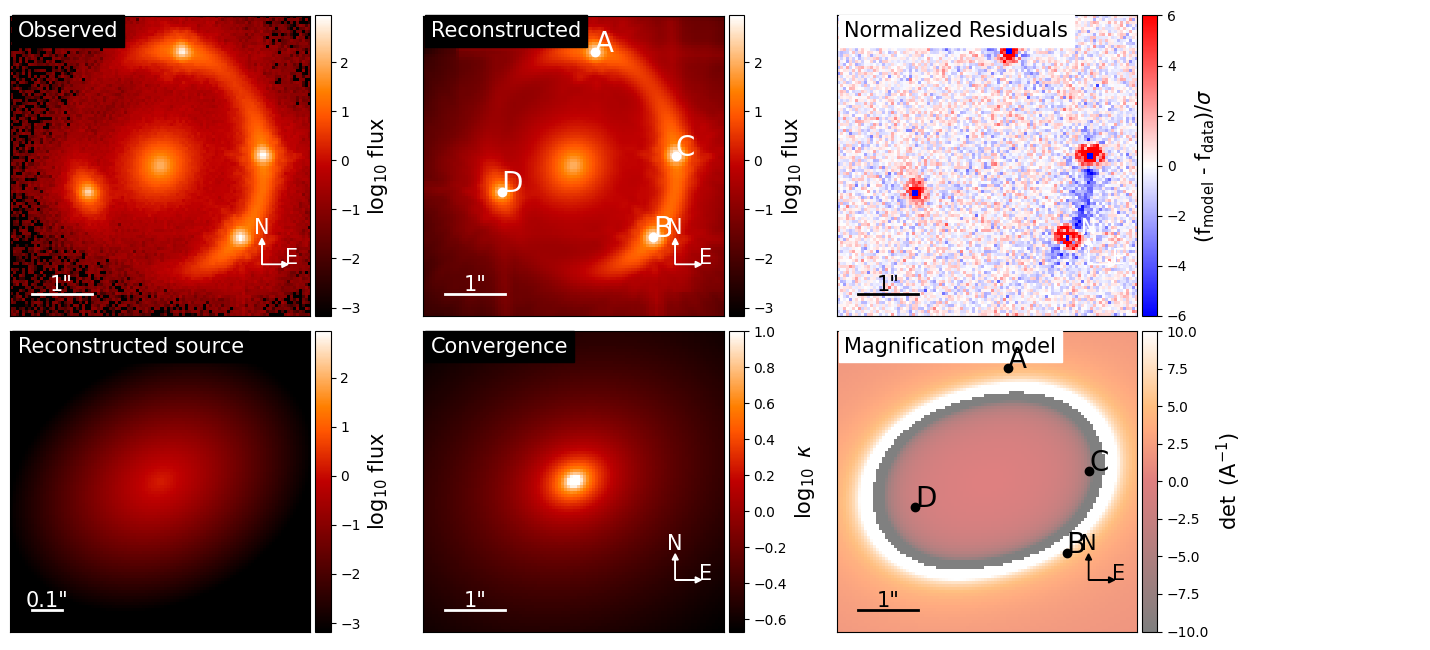

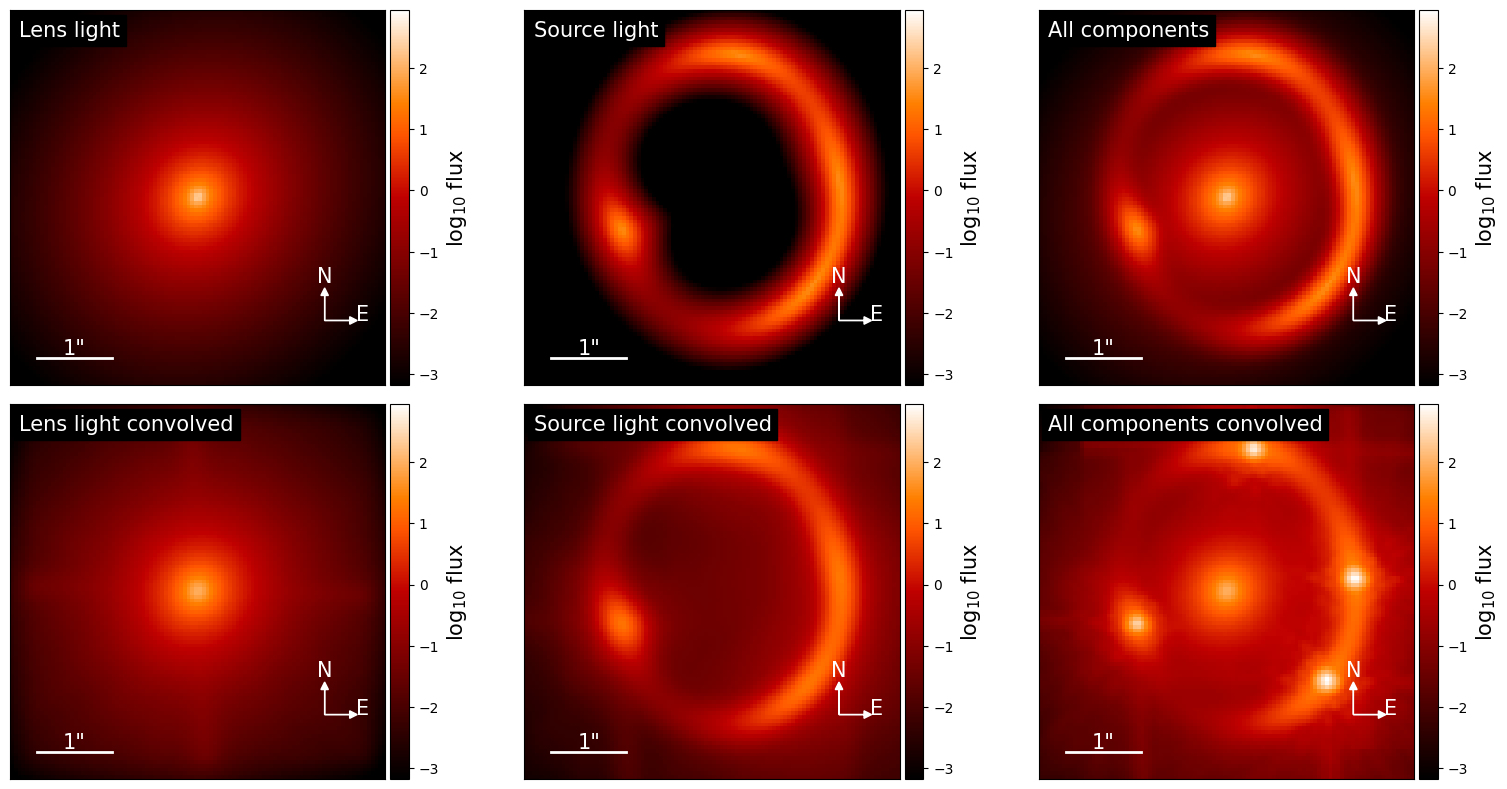

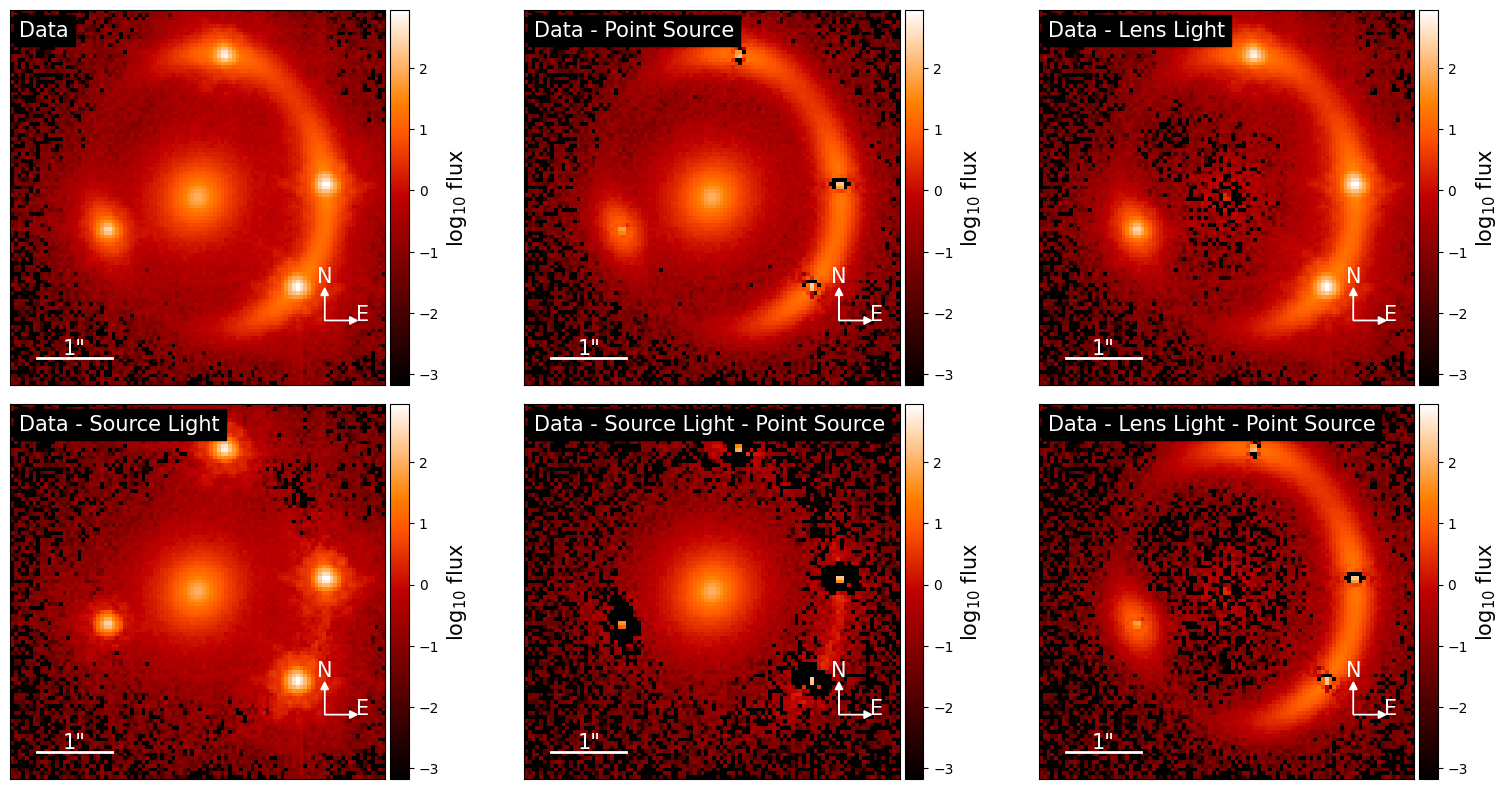

In [6]:
redo_fit = False

# now we first run a PSO with the wrong PSF
psf_iter_factor = 0.2
psf_iter_num = 100
sigma_scale = 0.1
# numerical options and fitting sequences

num_source_model = len(source_model_list)

kwargs_constraints = {'joint_source_with_point_source': [[0, 0]],
                      'num_point_source_list': [4],
                      'solver_type': 'PROFILE_SHEAR',  # 'PROFILE', 'PROFILE_SHEAR', 'ELLIPSE', 'CENTER'
                      'Ddt_sampling': True,
                              }

kwargs_likelihood = {'check_bounds': True,
                             'force_no_add_image': False,
                             'source_marg': False,
                             'image_position_uncertainty': 0.004,
                             'check_matched_source_position': True,
                             'source_position_tolerance': 0.001,
                             'time_delay_likelihood': True,
                             }

image_band = [kwargs_data, kwargs_psf, kwargs_numerics]
multi_band_list = [image_band]
kwargs_data_joint = {'multi_band_list': multi_band_list, 'multi_band_type': 'multi-linear',
                    'time_delays_measured': dt_measured,
                    'time_delays_uncertainties': dt_sigma,}

kwargs_init = [kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_ps]

from lenstronomy.Workflow.fitting_sequence import FittingSequence

mpi = False  # MPI possible, but not supported through that notebook.
fitting_kwargs_list = [['update_settings', {'lens_add_fixed': [[0, ['gamma']]]}],
                ['PSO', {'sigma_scale': sigma_scale, 'n_particles': 100, 'n_iterations': 100}],]

if not os.path.exists('./fitsequence.pkl') or redo_fit:
        from lenstronomy.Workflow.fitting_sequence import FittingSequence
        fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)
        start_time = time.time()
        chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
        kwargs_result = fitting_seq.best_fit()
        end_time = time.time()
        print(end_time - start_time, 'total time needed for computation')
        print('============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ ')
        pkl.dump(fitting_seq, open('fitsequence.pkl', 'wb'))
        pkl.dump(chain_list, open('chainlist.pkl', 'wb'))

else:
        print('Loading from pickle file.')
        fitting_seq = pkl.load(open('fitsequence.pkl', 'rb'))
        chain_list = pkl.load(open('chainlist.pkl', 'rb'))
        kwargs_result = fitting_seq.best_fit()

# here is the output

from lenstronomy.Plots import chain_plot
from lenstronomy.Plots.model_plot import ModelPlot
modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")
f, axes = modelPlot.plot_main(); f.show()
f, axes = modelPlot.plot_separate(); f.show()
f, axes = modelPlot.plot_subtract_from_data_all(); f.show()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/martin/Desktop/TDLMC/lenstronomy/lenstronomy/Workflow/psf_fitting.py:399: UserWarning: Negative or zero values in the noise maps. Replacing these pixels with the median value.
  warnings.warn(


### Step 1, fixing : ['background'] ###


optax.adabelief: 100%|██████████| 500/500 [00:13<00:00, 37.56it/s]
/Users/martin/Desktop/modules/starred/starred/utils/noise_utils.py:52: RuntimeWarning: Mean of empty slice
  noise_map = np.nanmean(centered_masked_noise_maps, axis=0)


Step 1/2 took 13 seconds
Kwargs partial at step 1/2 {'kwargs_moffat': {'fwhm_x': Array([1.7868354], dtype=float32), 'fwhm_y': Array([1.6850523], dtype=float32), 'phi': Array([-0.42739138], dtype=float32), 'beta': Array([2.0912285], dtype=float32), 'C': Array([1.0613872], dtype=float32)}, 'kwargs_gaussian': {'a': Array([1.3004495 , 1.9628215 , 2.0233462 , 0.56087583], dtype=float32), 'x0': Array([-0.44622955, -0.00329583,  0.49304396, -0.4462836 ], dtype=float32), 'y0': Array([ 0.3494961 , -0.35200995, -0.17879504, -0.18685012], dtype=float32)}, 'kwargs_background': {'background': Array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)}}
LogL :  66866.61
Overall Reduced Chi2 :  4.037351
### Step 2, fixing : ['moffat'] ###


optax.adabelief: 100%|██████████| 500/500 [01:13<00:00,  6.76it/s]


Step 2/2 took 74 seconds
Kwargs partial at step 2/2 {'kwargs_moffat': {'fwhm_x': Array([1.7868354], dtype=float32), 'fwhm_y': Array([1.6850523], dtype=float32), 'phi': Array([-0.42739138], dtype=float32), 'beta': Array([2.0912285], dtype=float32), 'C': Array([1.0613872], dtype=float32)}, 'kwargs_gaussian': {'a': Array([1.1325598 , 1.7689406 , 1.825574  , 0.49072513], dtype=float32), 'x0': Array([-0.44381943,  0.00095742,  0.4960301 , -0.4452449 ], dtype=float32), 'y0': Array([ 0.32495078, -0.37070277, -0.1898343 , -0.1990189 ], dtype=float32)}, 'kwargs_background': {'background': Array([-5.1305740e-04, -3.8812694e-05,  1.5789986e-04, ...,
        1.9963998e-04, -2.2888464e-05, -4.9704377e-04], dtype=float32)}}
LogL :  78607.72
Overall Reduced Chi2 :  2.19299


/Users/martin/Desktop/TDLMC/lenstronomy/lenstronomy/Data/psf.py:80: UserWarning: Input PSF model has at least one negative element, which is unphysical except for a PSF of an interferometric array.
  warnings.warn(


### Step 1, fixing : ['background'] ###


optax.adabelief: 100%|██████████| 500/500 [00:10<00:00, 49.39it/s]


Step 1/2 took 10 seconds
Kwargs partial at step 1/2 {'kwargs_moffat': {'fwhm_x': Array([1.5797043], dtype=float32), 'fwhm_y': Array([1.490349], dtype=float32), 'phi': Array([-0.42033258], dtype=float32), 'beta': Array([1.8548305], dtype=float32), 'C': Array([1.3506466], dtype=float32)}, 'kwargs_gaussian': {'a': Array([1.5544794, 2.3363688, 2.4145315, 0.6689111], dtype=float32), 'x0': Array([-0.44340762, -0.00361497,  0.49254766, -0.44419336], dtype=float32), 'y0': Array([ 0.34064206, -0.35106   , -0.17737626, -0.18480314], dtype=float32)}, 'kwargs_background': {'background': Array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)}}
LogL :  42632.71
Overall Reduced Chi2 :  2.5741282
### Step 2, fixing : ['moffat'] ###


optax.adabelief: 100%|██████████| 500/500 [01:34<00:00,  5.31it/s]


Step 2/2 took 94 seconds
Kwargs partial at step 2/2 {'kwargs_moffat': {'fwhm_x': Array([1.5797043], dtype=float32), 'fwhm_y': Array([1.490349], dtype=float32), 'phi': Array([-0.42033258], dtype=float32), 'beta': Array([1.8548305], dtype=float32), 'C': Array([1.3506466], dtype=float32)}, 'kwargs_gaussian': {'a': Array([1.3824414, 2.1484225, 2.2224107, 0.5876336], dtype=float32), 'x0': Array([-0.44699422, -0.0035992 ,  0.4917667 , -0.44807804], dtype=float32), 'y0': Array([ 0.32291096, -0.3743701 , -0.19429986, -0.20239495], dtype=float32)}, 'kwargs_background': {'background': Array([ 1.9920016e-04,  2.7192378e-04, -6.0641692e-06, ...,
       -2.9970738e-04,  2.3296473e-04, -9.0660818e-05], dtype=float32)}}
LogL :  55892.582
Overall Reduced Chi2 :  1.0180006
### Step 1, fixing : ['background'] ###


optax.adabelief: 100%|██████████| 500/500 [00:09<00:00, 55.30it/s]


Step 1/2 took  9 seconds
Kwargs partial at step 1/2 {'kwargs_moffat': {'fwhm_x': Array([1.6380465], dtype=float32), 'fwhm_y': Array([1.5468638], dtype=float32), 'phi': Array([-0.4370787], dtype=float32), 'beta': Array([1.9256285], dtype=float32), 'C': Array([0.9592198], dtype=float32)}, 'kwargs_gaussian': {'a': Array([1.4794647 , 2.2256901 , 2.3049936 , 0.63642156], dtype=float32), 'x0': Array([-0.444511  , -0.00351158,  0.49298015, -0.44579253], dtype=float32), 'y0': Array([ 0.34343424, -0.35158262, -0.17694254, -0.18576822], dtype=float32)}, 'kwargs_background': {'background': Array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)}}
LogL :  41677.48
Overall Reduced Chi2 :  2.516452
### Step 2, fixing : ['moffat'] ###


optax.adabelief: 100%|██████████| 500/500 [01:13<00:00,  6.83it/s]


Step 2/2 took 73 seconds
Kwargs partial at step 2/2 {'kwargs_moffat': {'fwhm_x': Array([1.6380465], dtype=float32), 'fwhm_y': Array([1.5468638], dtype=float32), 'phi': Array([-0.4370787], dtype=float32), 'beta': Array([1.9256285], dtype=float32), 'C': Array([0.9592198], dtype=float32)}, 'kwargs_gaussian': {'a': Array([1.2966391, 2.0308907, 2.1067843, 0.5325912], dtype=float32), 'x0': Array([-0.43147233,  0.01628953,  0.50849277, -0.43378973], dtype=float32), 'y0': Array([ 0.30950606, -0.38826844, -0.20690933, -0.21634257], dtype=float32)}, 'kwargs_background': {'background': Array([-8.0461090e-05, -1.3188618e-04, -6.4160980e-05, ...,
        2.7849059e-05,  3.5220870e-05, -9.6407042e-05], dtype=float32)}}
LogL :  42125.445
Overall Reduced Chi2 :  0.9820584
iteration of step 2 gave best reconstruction.
log likelihood before: -22067.56446267387 and log likelihood after: -7037.487849042049


/Users/martin/Desktop/TDLMC/lenstronomy/lenstronomy/Plots/chain_plot.py:159: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(psf_out), origin="lower", **kwargs)
/Users/martin/Desktop/TDLMC/lenstronomy/lenstronomy/Plots/chain_plot.py:200: RuntimeWarning: divide by zero encountered in log10
  np.log10(psf_error_map * psf.kernel_point_source**2),
/var/folders/k5/9nxb2fnj4zsbb1nrtpvbf8000000gn/T/ipykernel_59288/1714751780.py:41: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()
/Users/martin/Desktop/TDLMC/lenstronomy/lenstronomy/Plots/model_band_plot.py:67: RuntimeWarning: invalid value encountered in log10
  log_model = np.log10(model)


-1.4074975698084098 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  1.40749756980841


/Users/martin/Desktop/TDLMC/lenstronomy/lenstronomy/Plots/model_band_plot.py:160: RuntimeWarning: invalid value encountered in log10
  np.log10(self._data),
/Users/martin/Desktop/TDLMC/lenstronomy/lenstronomy/Plots/model_band_plot.py:223: RuntimeWarning: invalid value encountered in log10
  np.log10(self._model),
/Users/martin/Desktop/TDLMC/lenstronomy/lenstronomy/Plots/model_band_plot.py:1206: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()
/var/folders/k5/9nxb2fnj4zsbb1nrtpvbf8000000gn/T/ipykernel_59288/1714751780.py:44: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()
/Users/martin/Desktop/TDLMC/lenstronomy/lenstronomy/Plots/model_band_plot.py:1101: RuntimeWarning: invalid value encountered in log10
  np.log10(model),
/var/folders/k5/9nxb2fnj4zsbb1nrtpvbf8000000gn/T/ipykernel_59288/171475

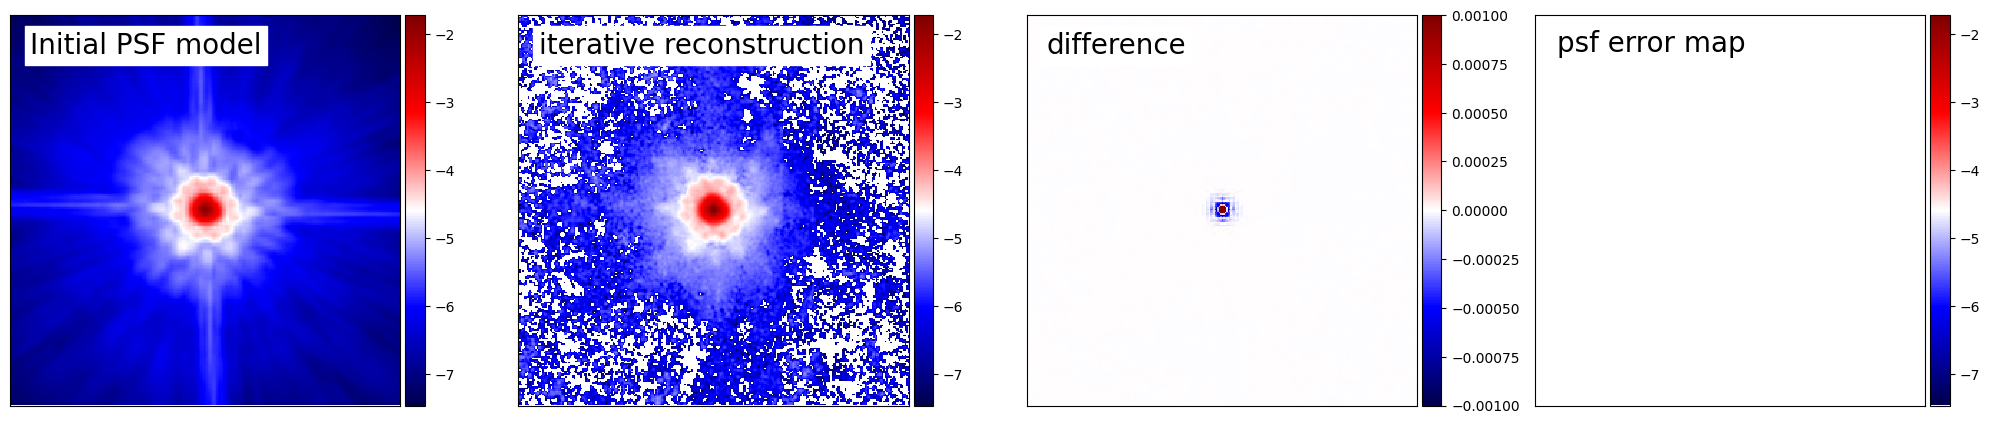

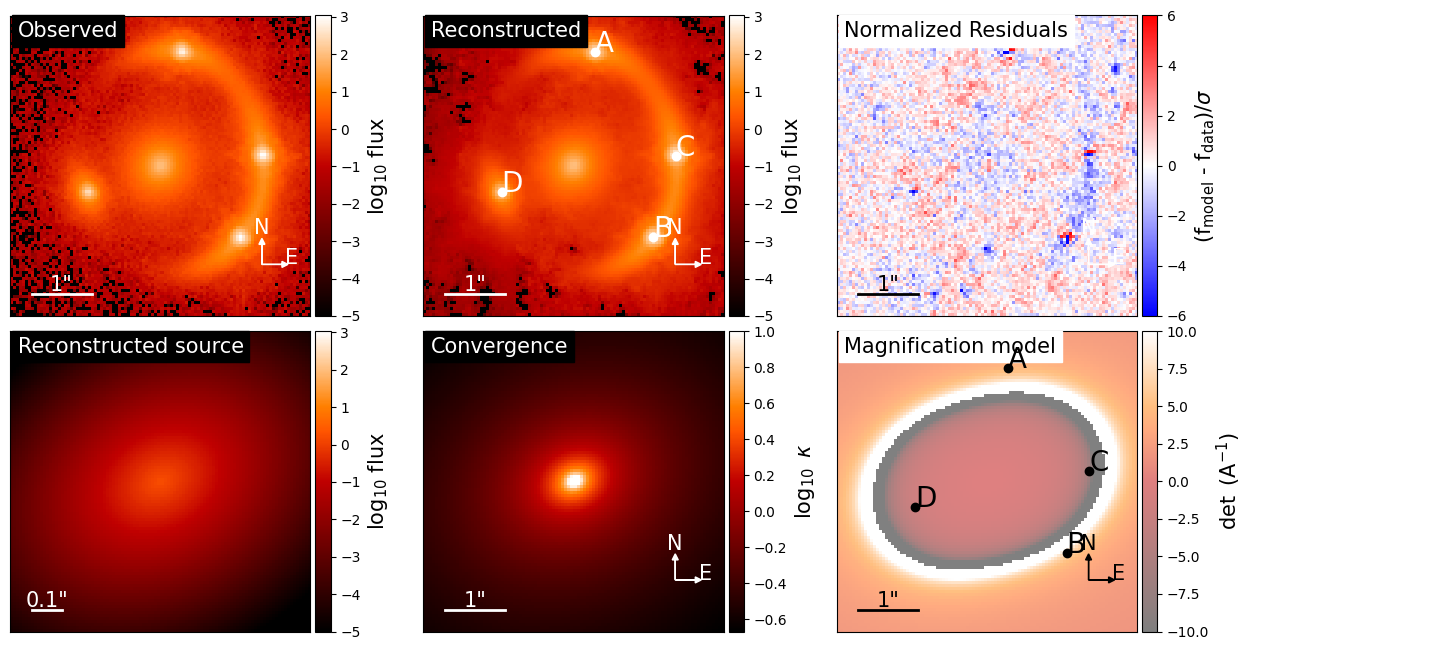

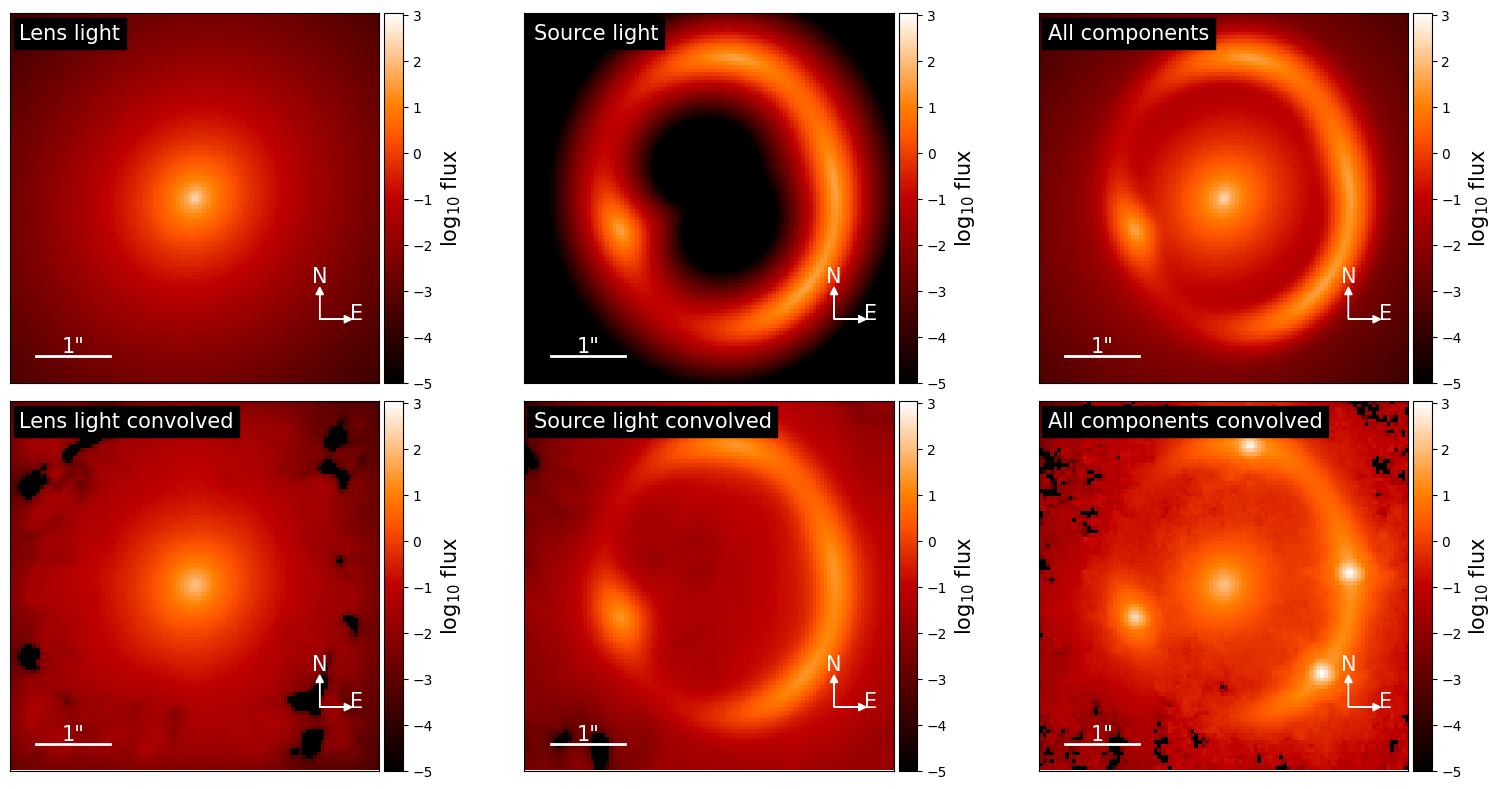

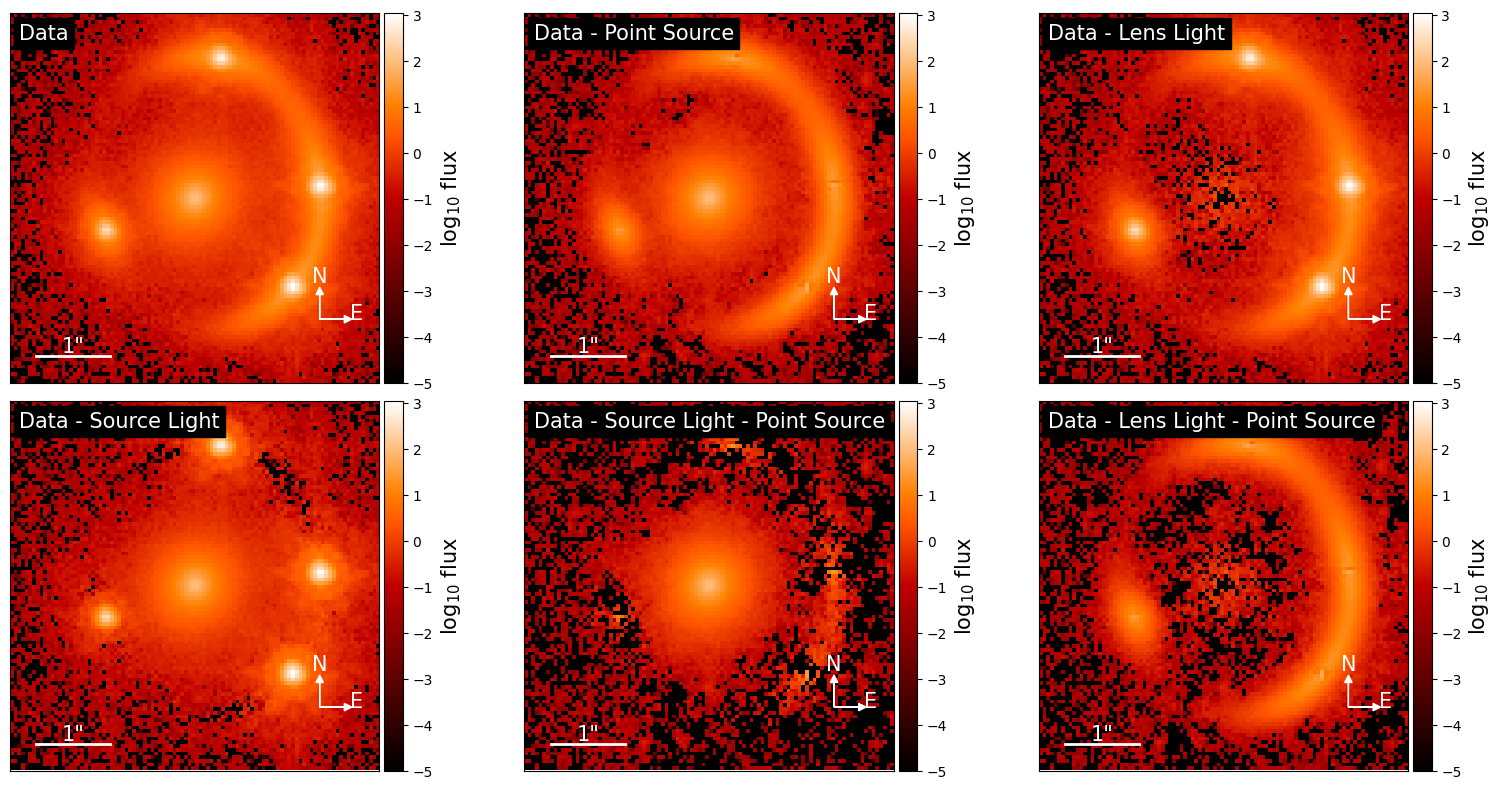

In [8]:
%load_ext autoreload
%autoreload 2

#now we run an iterative PSF reconstruction with the best fit model of the previous run
method_PSF_iteration = 'STARRED' #use 'STARRED' to use the STARRED method for PSF reconstruction or 'stack' to use the standard lenstronomy stacking method

kwargs_lbfgs = {'maxiter':1000}

kwargs_optax1 = {'max_iterations': 500, 'min_iterations': None,
                'init_learning_rate': 1e-2, 'schedule_learning_rate': True,
                'progress_bar': True} 

if method_PSF_iteration == 'STARRED':
    kwargs_psf_iter = { 
                    'keep_psf_error_map': True, 
                    'psf_symmetry': 1, 
                    'block_center_neighbour': 0.05,
                    'num_iter': 3, #we run STARRED more than once, to see if the chi2 keeps improving after redoing the linear inversion with the new PSF. 
                    'psf_iter_factor': 1, #We fully update the PSF at each iteration, if the fit improves
                    'kwargs_starred': {'verbose':True, 'lambda_scales':3, 'lambda_hf':3, #Choose regularisation parameters, lambda_scales and lambda_hf should be 2 or 3 if the noise is correctly scaled 
                                       'optim_list':['adabelief', 'adabelief'], 'kwargs_optim_list':[kwargs_optax1, kwargs_optax1],#Choose the optimisers to use, and pass the kwargs accordingly. One for the Moffat fit, one for the full PSF fit. 
                                       }, 
                    'use_starred': True, 
                    } 

else: 
    kwargs_psf_iter = {'stacking_method': 'median', 
                    'keep_psf_error_map': True, 
                    'psf_symmetry': 2, 
                    'block_center_neighbour': 0.05,
                    'num_iter': psf_iter_num, 
                    'psf_iter_factor': psf_iter_factor}

fitting_kwargs_list = [['psf_iteration', kwargs_psf_iter]]
chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
#lens_result, source_result, lens_light_result, ps_result, cosmo_result

multi_band_list = fitting_seq.multi_band_list
kwargs_psf_updated = multi_band_list[0][1]
f, axes = chain_plot.psf_iteration_compare(kwargs_psf_updated)
f.show()
modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")
f, axes = modelPlot.plot_main()
f.show()
f, axes = modelPlot.plot_separate()
f.show()
f, axes = modelPlot.plot_subtract_from_data_all()
f.show()



Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
Max iteration reached! Stopping.
-1.302900807745714 reduced X^2 of best position
-6498.217778631749 log likelihood
9975 effective number of data points
[{'theta_E': 1.6538384177830043, 'gamma': 1.9989920319892713, 'e1': 0.08147196270523069, 'e2': 0.09078721446205495, 'center_x': 0.014030214229862096, 'center_y': 0.007189277530610161}, {'gamma1': -0.06349852998479961, 'gamma2': -0.007973173718957817, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.10033272942802798, 'n_sersic': 0.931665616199429, 'e1': 0.07784433447414482, 'e2': 0.10620798687957775, 'center_x': 0.2137519623709072, 'center_y': 0.10566517381022243}] source result
[{'amp': 1, 'R_sersic': 0.19683005667026965, 'n_sersic': 1.9741115902203228, 'e1': -0.015041960046717071, 'e2': 0.05010619183411827, 'center_x': -0.00013273039574940854, 'center_y': 0.0008561591756572656}] lens light result
[{'ra_image': array([ 0.35272022,  1.32500064,  1.69955298, -1.19739434]),

optax.adabelief: 100%|██████████| 500/500 [00:09<00:00, 54.90it/s]


Step 1/2 took  9 seconds
Kwargs partial at step 1/2 {'kwargs_moffat': {'fwhm_x': Array([1.6255733], dtype=float32), 'fwhm_y': Array([1.5310127], dtype=float32), 'phi': Array([-0.43339786], dtype=float32), 'beta': Array([1.9151084], dtype=float32), 'C': Array([1.2860068], dtype=float32)}, 'kwargs_gaussian': {'a': Array([1.4980745, 2.246934 , 2.32743  , 0.6472287], dtype=float32), 'x0': Array([-0.44398367, -0.00382141,  0.4932783 , -0.44344154], dtype=float32), 'y0': Array([ 0.34299058, -0.35168886, -0.17635812, -0.18496779], dtype=float32)}, 'kwargs_background': {'background': Array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)}}
LogL :  40621.605
Overall Reduced Chi2 :  2.4526992
### Step 2, fixing : ['moffat'] ###


optax.adabelief: 100%|██████████| 500/500 [00:53<00:00,  9.30it/s]


Step 2/2 took 54 seconds
Kwargs partial at step 2/2 {'kwargs_moffat': {'fwhm_x': Array([1.6255733], dtype=float32), 'fwhm_y': Array([1.5310127], dtype=float32), 'phi': Array([-0.43339786], dtype=float32), 'beta': Array([1.9151084], dtype=float32), 'C': Array([1.2860068], dtype=float32)}, 'kwargs_gaussian': {'a': Array([1.3269345 , 2.0585127 , 2.1337223 , 0.56798697], dtype=float32), 'x0': Array([-0.4371417 ,  0.00811063,  0.50249326, -0.4378316 ], dtype=float32), 'y0': Array([ 0.31823945, -0.3790206 , -0.19719554, -0.20610106], dtype=float32)}, 'kwargs_background': {'background': Array([-5.6237582e-04,  2.0242296e-04, -3.7455081e-06, ...,
        1.6502028e-04,  2.3095585e-04, -2.7373698e-04], dtype=float32)}}
LogL :  55283.14
Overall Reduced Chi2 :  0.9322072
### Step 1, fixing : ['background'] ###


optax.adabelief: 100%|██████████| 500/500 [00:07<00:00, 67.95it/s]


Step 1/2 took  7 seconds
Kwargs partial at step 1/2 {'kwargs_moffat': {'fwhm_x': Array([1.5960068], dtype=float32), 'fwhm_y': Array([1.5007799], dtype=float32), 'phi': Array([-0.41589892], dtype=float32), 'beta': Array([1.8701143], dtype=float32), 'C': Array([1.3617061], dtype=float32)}, 'kwargs_gaussian': {'a': Array([1.5321904 , 2.2913105 , 2.3744512 , 0.65487826], dtype=float32), 'x0': Array([-0.44323722, -0.00329696,  0.49306288, -0.4409249 ], dtype=float32), 'y0': Array([ 0.34114295, -0.35177544, -0.17704278, -0.18415299], dtype=float32)}, 'kwargs_background': {'background': Array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)}}
LogL :  45818.02
Overall Reduced Chi2 :  2.7664545
### Step 2, fixing : ['moffat'] ###


optax.adabelief: 100%|██████████| 500/500 [00:54<00:00,  9.12it/s]


Step 2/2 took 55 seconds
Kwargs partial at step 2/2 {'kwargs_moffat': {'fwhm_x': Array([1.5960068], dtype=float32), 'fwhm_y': Array([1.5007799], dtype=float32), 'phi': Array([-0.41589892], dtype=float32), 'beta': Array([1.8701143], dtype=float32), 'C': Array([1.3617061], dtype=float32)}, 'kwargs_gaussian': {'a': Array([1.3595066, 2.1045835, 2.1820843, 0.5780874], dtype=float32), 'x0': Array([-0.4471906 , -0.00420627,  0.49174073, -0.44585323], dtype=float32), 'y0': Array([ 0.31274402, -0.38466066, -0.20399633, -0.21113752], dtype=float32)}, 'kwargs_background': {'background': Array([ 7.7842073e-05, -3.6658277e-04,  1.1996040e-04, ...,
        6.9005822e-05,  2.5063995e-04, -4.0993825e-04], dtype=float32)}}
LogL :  55331.438
Overall Reduced Chi2 :  1.0066102
### Step 1, fixing : ['background'] ###


optax.adabelief: 100%|██████████| 500/500 [00:10<00:00, 45.94it/s]


Step 1/2 took 11 seconds
Kwargs partial at step 1/2 {'kwargs_moffat': {'fwhm_x': Array([1.6860088], dtype=float32), 'fwhm_y': Array([1.5879458], dtype=float32), 'phi': Array([-0.43251365], dtype=float32), 'beta': Array([1.9845386], dtype=float32), 'C': Array([0.86942625], dtype=float32)}, 'kwargs_gaussian': {'a': Array([1.4164605, 2.1378722, 2.2132604, 0.6124567], dtype=float32), 'x0': Array([-0.4444347 , -0.00302731,  0.49255487, -0.44423813], dtype=float32), 'y0': Array([ 0.3443914 , -0.35249338, -0.1775801 , -0.18587287], dtype=float32)}, 'kwargs_background': {'background': Array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)}}
LogL :  42720.895
Overall Reduced Chi2 :  2.5794528
### Step 2, fixing : ['moffat'] ###


optax.adabelief: 100%|██████████| 500/500 [01:07<00:00,  7.45it/s]


Step 2/2 took 67 seconds
Kwargs partial at step 2/2 {'kwargs_moffat': {'fwhm_x': Array([1.6860088], dtype=float32), 'fwhm_y': Array([1.5879458], dtype=float32), 'phi': Array([-0.43251365], dtype=float32), 'beta': Array([1.9845386], dtype=float32), 'C': Array([0.86942625], dtype=float32)}, 'kwargs_gaussian': {'a': Array([1.2331349 , 1.9416593 , 2.015234  , 0.50278974], dtype=float32), 'x0': Array([-0.41565365,  0.03278879,  0.52321696, -0.41682062], dtype=float32), 'y0': Array([ 0.295929  , -0.401604  , -0.21981606, -0.2282494 ], dtype=float32)}, 'kwargs_background': {'background': Array([-1.2885175e-04, -2.3017373e-04, -1.0121472e-04, ...,
       -5.8566206e-06, -3.3173557e-05,  1.8662482e-05], dtype=float32)}}
LogL :  38821.625
Overall Reduced Chi2 :  0.95654786
iteration of step 0 gave best reconstruction.
log likelihood before: -6497.679122210708 and log likelihood after: -6497.679122210708
Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
Max iteration reached! Stopping.
-1.3027

optax.adabelief: 100%|██████████| 500/500 [00:08<00:00, 58.13it/s]


Step 1/2 took  9 seconds
Kwargs partial at step 1/2 {'kwargs_moffat': {'fwhm_x': Array([1.6248912], dtype=float32), 'fwhm_y': Array([1.530311], dtype=float32), 'phi': Array([-0.43275335], dtype=float32), 'beta': Array([1.914281], dtype=float32), 'C': Array([1.1808383], dtype=float32)}, 'kwargs_gaussian': {'a': Array([1.498984 , 2.2482443, 2.328839 , 0.6476343], dtype=float32), 'x0': Array([-0.44398686, -0.00381856,  0.4932869 , -0.44346696], dtype=float32), 'y0': Array([ 0.34293473, -0.3516901 , -0.1763579 , -0.18504411], dtype=float32)}, 'kwargs_background': {'background': Array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)}}
LogL :  40608.23
Overall Reduced Chi2 :  2.4518917
### Step 2, fixing : ['moffat'] ###


optax.adabelief: 100%|██████████| 500/500 [01:08<00:00,  7.34it/s]


Step 2/2 took 68 seconds
Kwargs partial at step 2/2 {'kwargs_moffat': {'fwhm_x': Array([1.6248912], dtype=float32), 'fwhm_y': Array([1.530311], dtype=float32), 'phi': Array([-0.43275335], dtype=float32), 'beta': Array([1.914281], dtype=float32), 'C': Array([1.1808383], dtype=float32)}, 'kwargs_gaussian': {'a': Array([1.3232336 , 2.0571556 , 2.1332347 , 0.56023306], dtype=float32), 'x0': Array([-0.43550703,  0.01026575,  0.50429803, -0.4363418 ], dtype=float32), 'y0': Array([ 0.31885624, -0.3785558 , -0.19683154, -0.20578396], dtype=float32)}, 'kwargs_background': {'background': Array([-3.3218414e-04, -8.1553990e-06, -3.4373815e-04, ...,
        4.7175316e-05, -1.3465315e-04,  1.4191234e-04], dtype=float32)}}
LogL :  50183.695
Overall Reduced Chi2 :  0.9200971
### Step 1, fixing : ['background'] ###


optax.adabelief: 100%|██████████| 500/500 [00:08<00:00, 59.81it/s]


Step 1/2 took  8 seconds
Kwargs partial at step 1/2 {'kwargs_moffat': {'fwhm_x': Array([1.5938575], dtype=float32), 'fwhm_y': Array([1.498115], dtype=float32), 'phi': Array([-0.41824946], dtype=float32), 'beta': Array([1.8674598], dtype=float32), 'C': Array([1.3408537], dtype=float32)}, 'kwargs_gaussian': {'a': Array([1.5343524 , 2.296742  , 2.3805666 , 0.65829766], dtype=float32), 'x0': Array([-0.44309548, -0.00343591,  0.49316868, -0.4414856 ], dtype=float32), 'y0': Array([ 0.34108874, -0.35182628, -0.1770392 , -0.18510592], dtype=float32)}, 'kwargs_background': {'background': Array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)}}
LogL :  44990.008
Overall Reduced Chi2 :  2.7164598
### Step 2, fixing : ['moffat'] ###


optax.adabelief: 100%|██████████| 500/500 [01:04<00:00,  7.73it/s]


Step 2/2 took 65 seconds
Kwargs partial at step 2/2 {'kwargs_moffat': {'fwhm_x': Array([1.5938575], dtype=float32), 'fwhm_y': Array([1.498115], dtype=float32), 'phi': Array([-0.41824946], dtype=float32), 'beta': Array([1.8674598], dtype=float32), 'C': Array([1.3408537], dtype=float32)}, 'kwargs_gaussian': {'a': Array([1.3617667, 2.109324 , 2.1875496, 0.5779112], dtype=float32), 'x0': Array([-0.44203743,  0.00172971,  0.49685156, -0.44143343], dtype=float32), 'y0': Array([ 0.32071787, -0.37679031, -0.19575255, -0.20403859], dtype=float32)}, 'kwargs_background': {'background': Array([ 5.9174880e-04, -5.7720632e-04, -1.2794016e-05, ...,
        8.9835201e-05,  4.2678392e-05, -2.0138438e-04], dtype=float32)}}
LogL :  54976.6
Overall Reduced Chi2 :  1.0067017
### Step 1, fixing : ['background'] ###


optax.adabelief: 100%|██████████| 500/500 [00:08<00:00, 59.05it/s]


Step 1/2 took  9 seconds
Kwargs partial at step 1/2 {'kwargs_moffat': {'fwhm_x': Array([1.6643511], dtype=float32), 'fwhm_y': Array([1.5671017], dtype=float32), 'phi': Array([-0.43038362], dtype=float32), 'beta': Array([1.9603531], dtype=float32), 'C': Array([1.0343692], dtype=float32)}, 'kwargs_gaussian': {'a': Array([1.4465368, 2.1773713, 2.2567465, 0.6219661], dtype=float32), 'x0': Array([-0.44427907, -0.00361101,  0.49329886, -0.4430574 ], dtype=float32), 'y0': Array([ 0.3439035 , -0.35225853, -0.17730798, -0.18554544], dtype=float32)}, 'kwargs_background': {'background': Array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)}}
LogL :  41810.848
Overall Reduced Chi2 :  2.5245047
### Step 2, fixing : ['moffat'] ###


optax.adabelief: 100%|██████████| 500/500 [01:04<00:00,  7.76it/s]


Step 2/2 took 64 seconds
Kwargs partial at step 2/2 {'kwargs_moffat': {'fwhm_x': Array([1.6643511], dtype=float32), 'fwhm_y': Array([1.5671017], dtype=float32), 'phi': Array([-0.43038362], dtype=float32), 'beta': Array([1.9603531], dtype=float32), 'C': Array([1.0343692], dtype=float32)}, 'kwargs_gaussian': {'a': Array([1.2674009 , 1.9834933 , 2.0597532 , 0.52900994], dtype=float32), 'x0': Array([-0.4345772 ,  0.01154947,  0.50515604, -0.43468264], dtype=float32), 'y0': Array([ 0.3010369 , -0.3963931 , -0.21508719, -0.22347951], dtype=float32)}, 'kwargs_background': {'background': Array([-8.6284890e-05, -4.0225390e-05,  1.4383630e-04, ...,
       -6.2713327e-05, -7.9147270e-05,  1.5053363e-04], dtype=float32)}}
LogL :  44499.434
Overall Reduced Chi2 :  0.9376729
iteration of step 0 gave best reconstruction.
log likelihood before: -6497.095104047669 and log likelihood after: -6497.095104047669


/var/folders/k5/9nxb2fnj4zsbb1nrtpvbf8000000gn/T/ipykernel_57716/2368943301.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


-1.299419020809534 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  1.2994190208095338


/var/folders/k5/9nxb2fnj4zsbb1nrtpvbf8000000gn/T/ipykernel_57716/2368943301.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()
/var/folders/k5/9nxb2fnj4zsbb1nrtpvbf8000000gn/T/ipykernel_57716/2368943301.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()
/var/folders/k5/9nxb2fnj4zsbb1nrtpvbf8000000gn/T/ipykernel_57716/2368943301.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


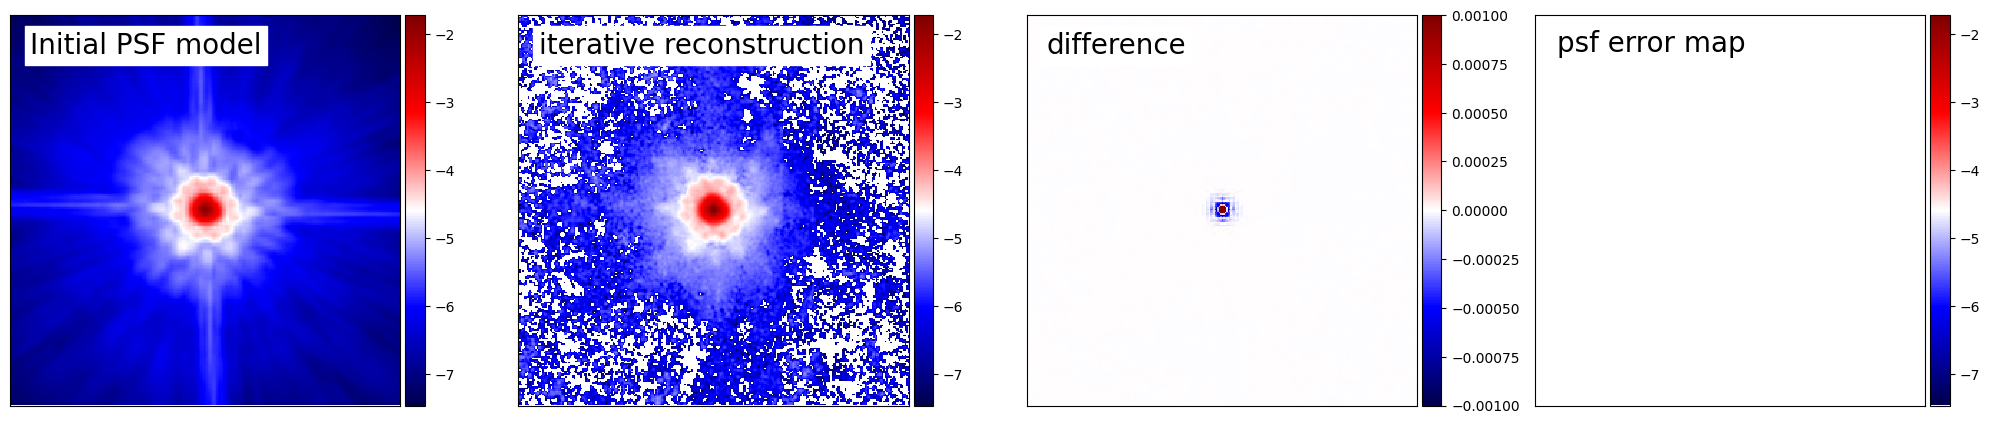

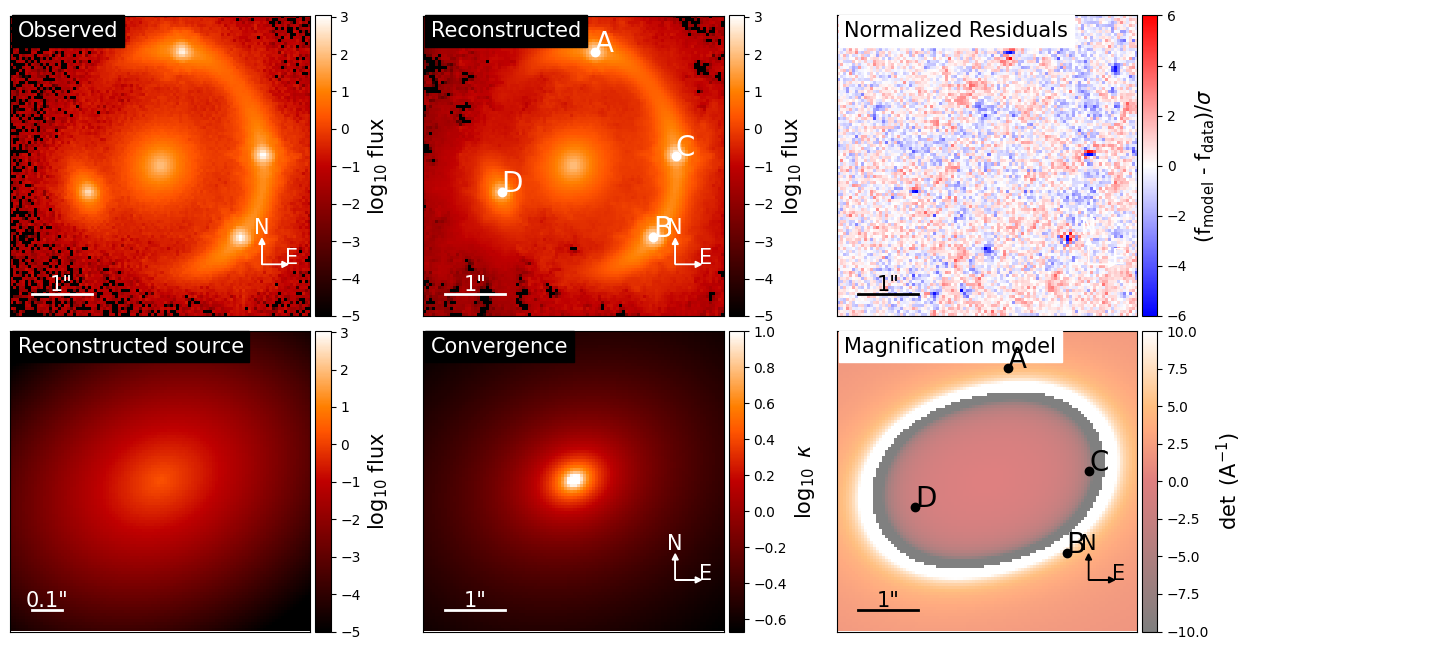

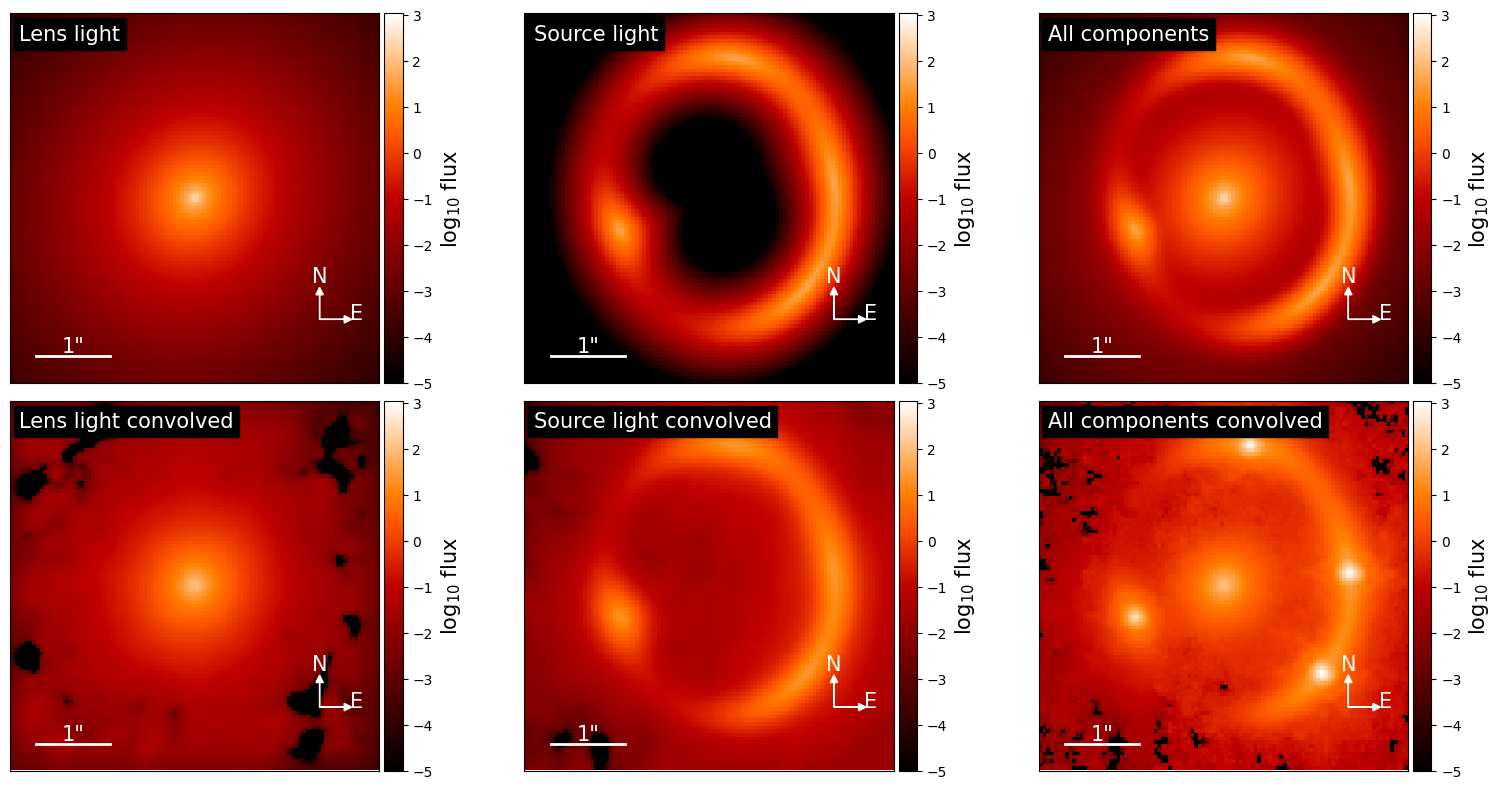

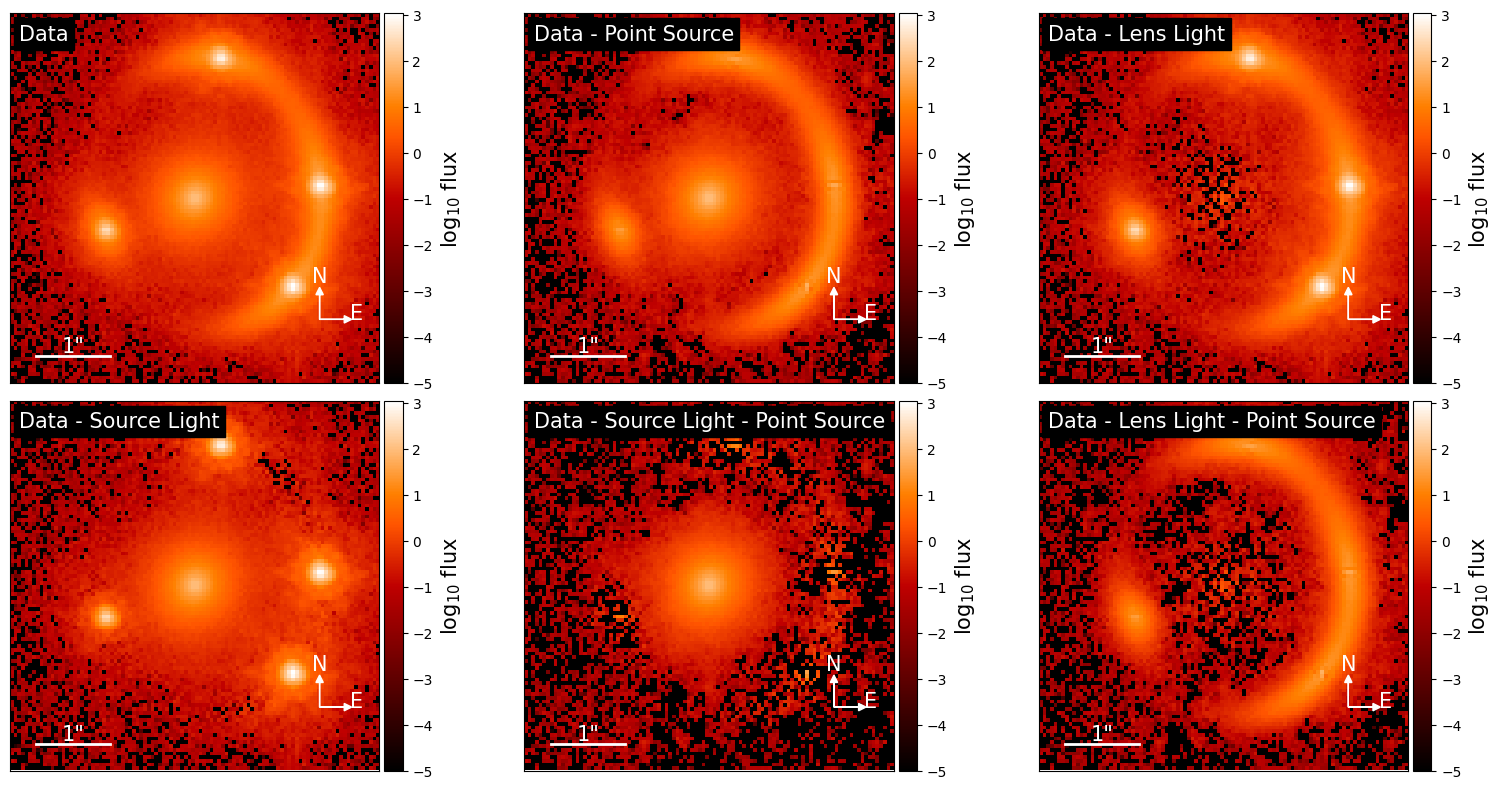

In [10]:
# and now we run another PSO optimization followed by another PSF iteration
fitting_kwargs_list = [['update_settings', {'lens_remove_fixed': [[0, ['gamma']]]}],
    ['PSO', {'sigma_scale': sigma_scale, 'n_particles': 100, 'n_iterations': 100}],
    ['psf_iteration', kwargs_psf_iter],
    ['PSO', {'sigma_scale': sigma_scale, 'n_particles': 100, 'n_iterations': 100}],
    ['psf_iteration', kwargs_psf_iter]]
chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

multi_band_list = fitting_seq.multi_band_list
kwargs_psf_updated = multi_band_list[0][1]
f, axes = chain_plot.psf_iteration_compare(kwargs_psf_updated)
f.show()
modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")
f, axes = modelPlot.plot_main()
f.show()
f, axes = modelPlot.plot_separate()
f.show()
f, axes = modelPlot.plot_subtract_from_data_all()
f.show()

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
Max iteration reached! Stopping.
-1.302774193375837 reduced X^2 of best position
-6497.586289461987 log likelihood
9975 effective number of data points
[{'theta_E': 1.6538529302403493, 'gamma': 1.9976204466513245, 'e1': 0.08127526079747424, 'e2': 0.09063346814037951, 'center_x': 0.014044380222469894, 'center_y': 0.007234416751757802}, {'gamma1': -0.06338196452311214, 'gamma2': -0.007906266478186525, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.10017682972772375, 'n_sersic': 0.9325402770754109, 'e1': 0.07721002280287696, 'e2': 0.10658486683625751, 'center_x': 0.2134540153550058, 'center_y': 0.1055405674882537}] source result
[{'amp': 1, 'R_sersic': 0.19677411690456068, 'n_sersic': 1.9683159113843336, 'e1': -0.015319067476847881, 'e2': 0.049708348339665774, 'center_x': -0.00014318603467872195, 'center_y': 0.0009419733960507328}] lens light result
[{'ra_image': array([ 0.35272269,  1.325     ,  1.69955428, -1.19739002])

  1%|          | 1/100 [00:10<17:58, 10.89s/it]/usr/local/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
100%|██████████| 100/100 [22:49<00:00, 13.70s/it]


Computing the MCMC...
Number of walkers =  220
Burn-in iterations:  50
Sampling iterations (in current run): 100
1382.326553106308 time taken for MCMC sampling


/var/folders/k5/9nxb2fnj4zsbb1nrtpvbf8000000gn/T/ipykernel_57716/4013513248.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


-1.3007081884637435 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  1.3007081884637441


/var/folders/k5/9nxb2fnj4zsbb1nrtpvbf8000000gn/T/ipykernel_57716/4013513248.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()
/var/folders/k5/9nxb2fnj4zsbb1nrtpvbf8000000gn/T/ipykernel_57716/4013513248.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()
/var/folders/k5/9nxb2fnj4zsbb1nrtpvbf8000000gn/T/ipykernel_57716/4013513248.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


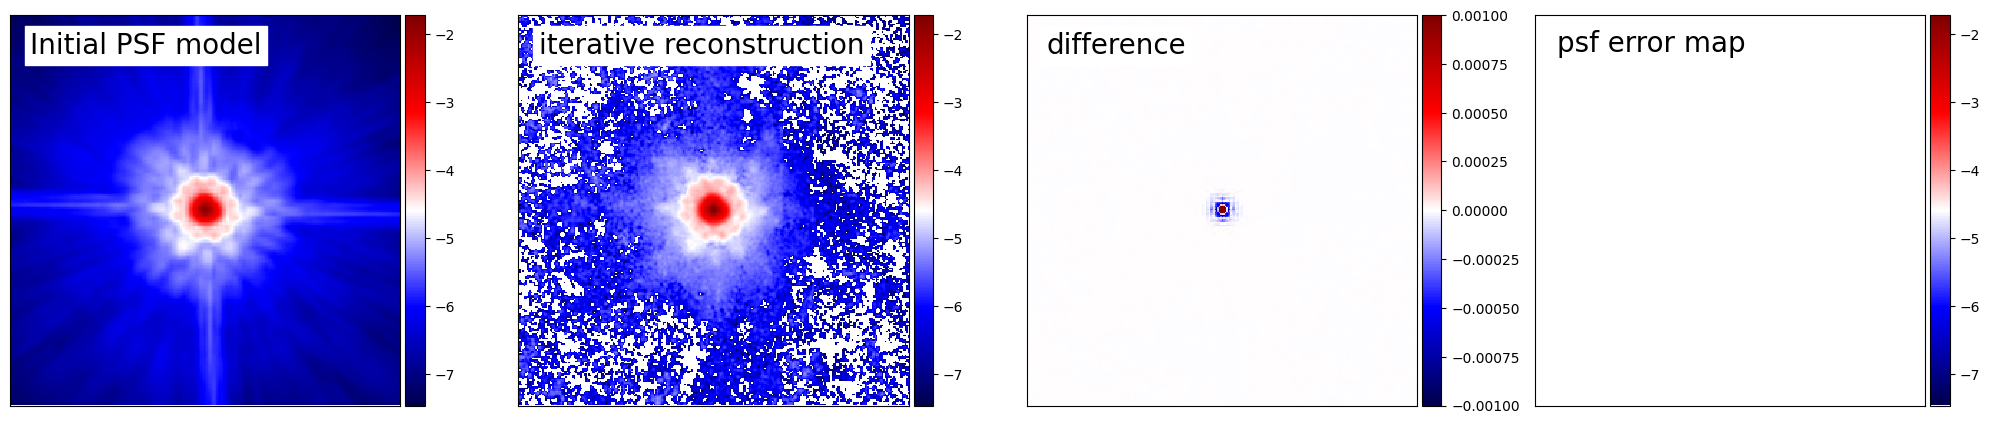

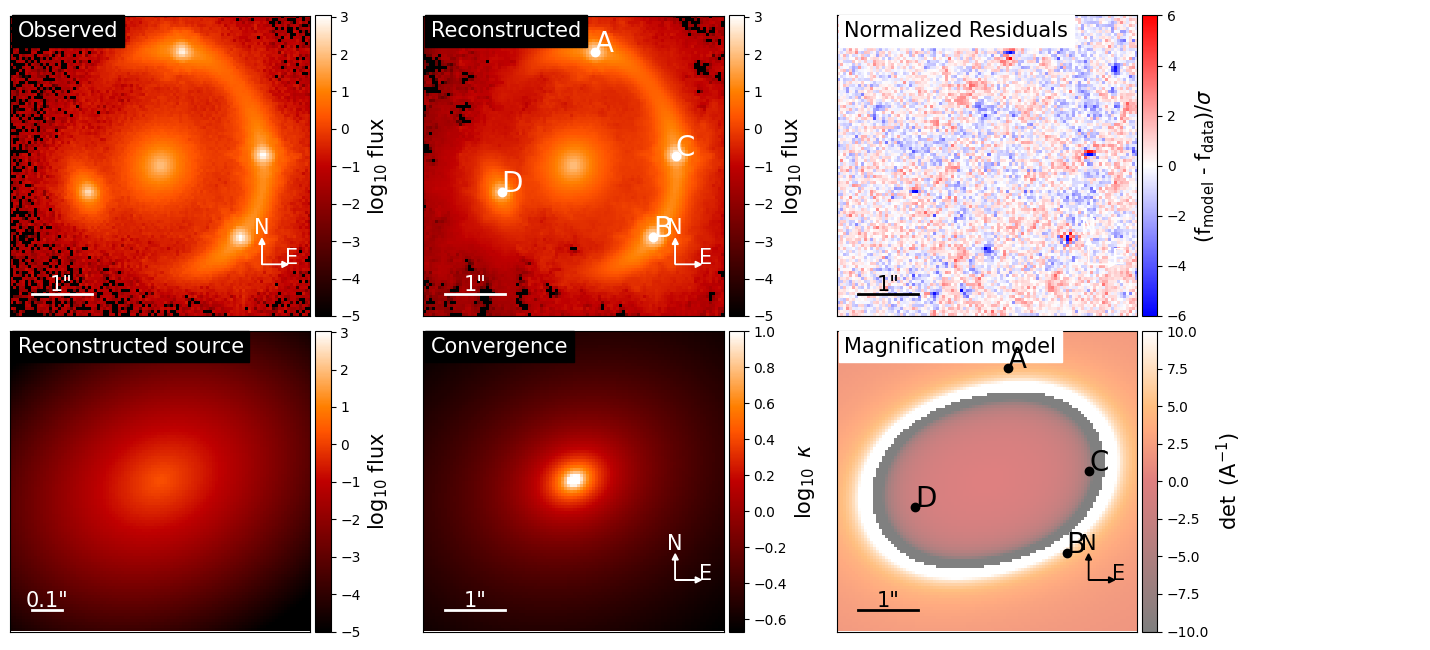

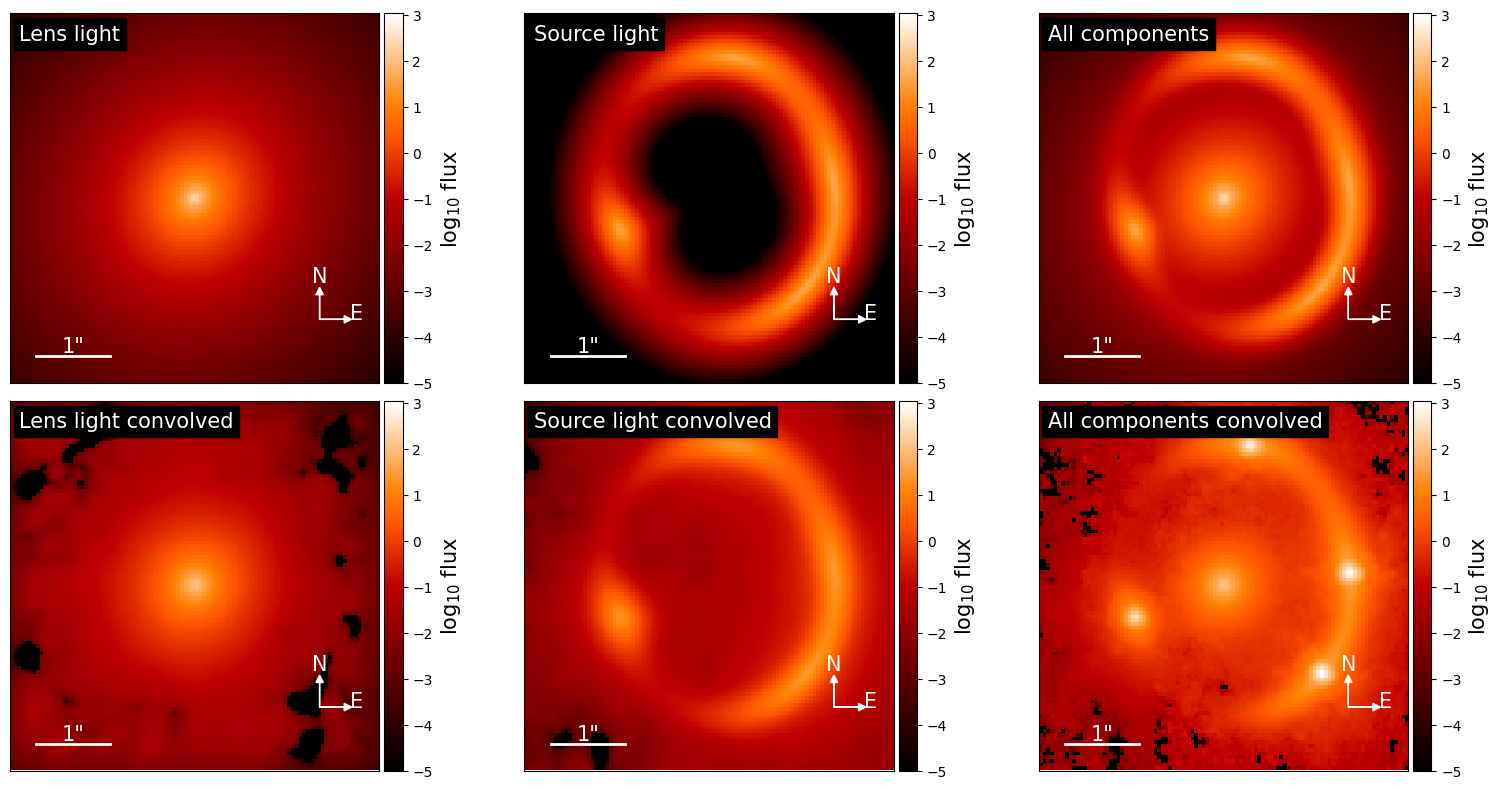

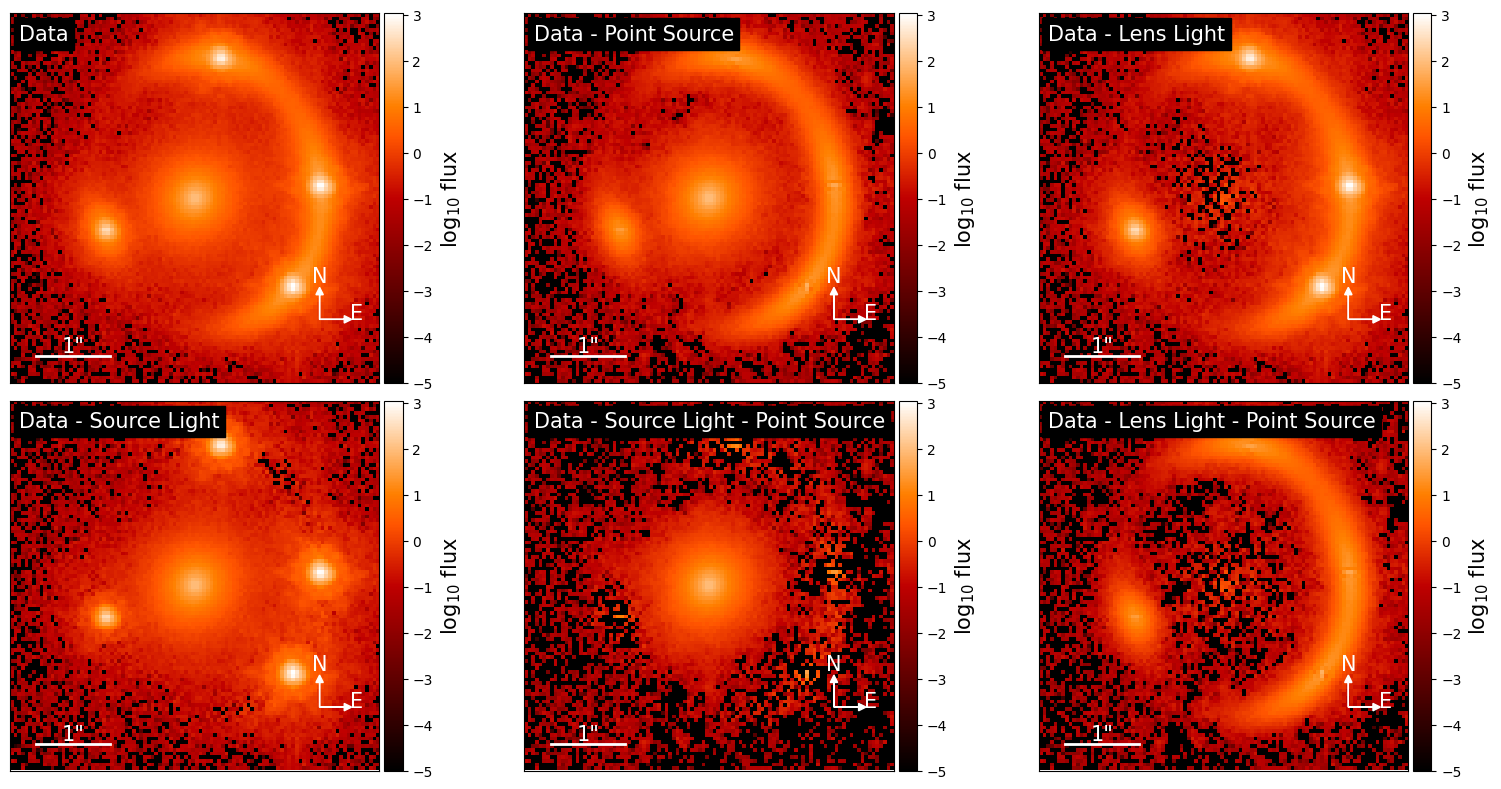

In [11]:
#and now we run the MCMC
fitting_kwargs_list = [
    ['PSO', {'sigma_scale': .1, 'n_particles': 100, 'n_iterations': 100}],
    ['MCMC', {'n_burn': 50, 'n_run': 50, 'walkerRatio': 10,'sigma_scale': .1}]
]
chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

multi_band_list = fitting_seq.multi_band_list
kwargs_psf_updated = multi_band_list[0][1]
f, axes = chain_plot.psf_iteration_compare(kwargs_psf_updated)
f.show()
modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")
f, axes = modelPlot.plot_main()
f.show()
f, axes = modelPlot.plot_separate()
f.show()
f, axes = modelPlot.plot_subtract_from_data_all()
f.show()

number of non-linear parameters in the MCMC process:  22
parameters in order:  ['gamma_lens0', 'gamma1_lens1', 'gamma2_lens1', 'R_sersic_source_light0', 'n_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'R_sersic_lens_light0', 'n_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0', 'ra_image', 'ra_image', 'ra_image', 'ra_image', 'dec_image', 'dec_image', 'dec_image', 'dec_image', 'D_dt']
number of evaluations in the MCMC process:  11000


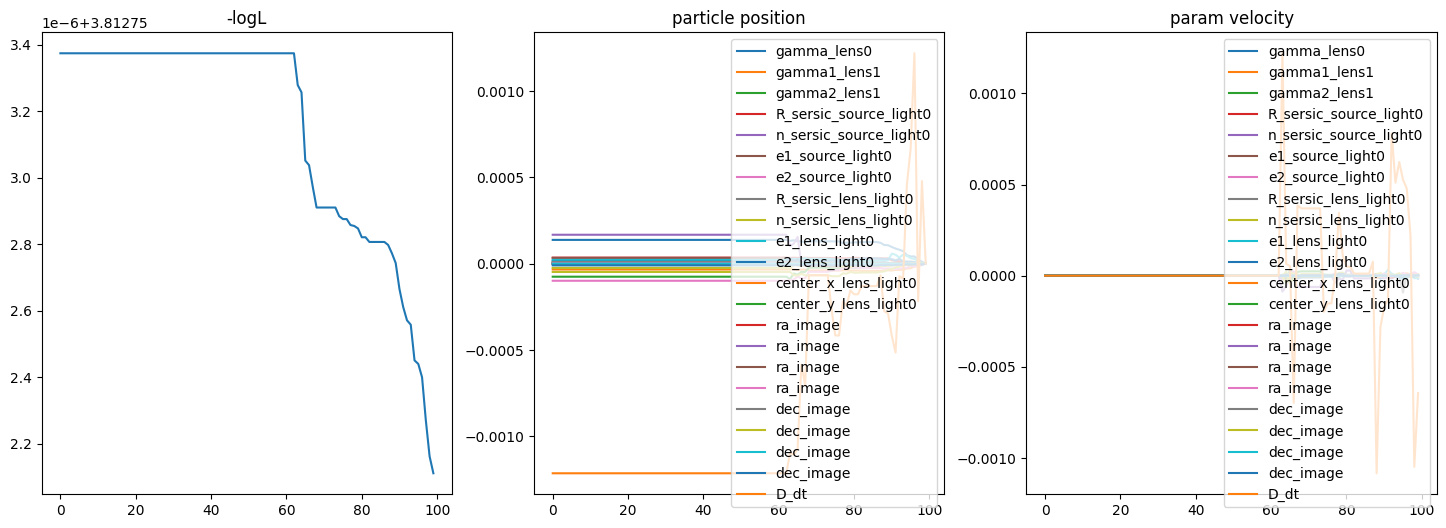

<Figure size 640x480 with 0 Axes>

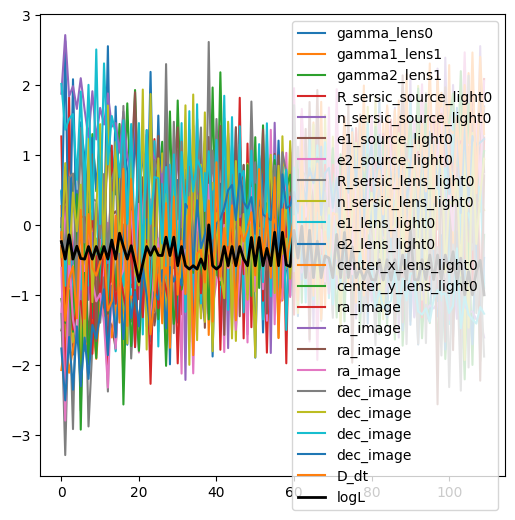

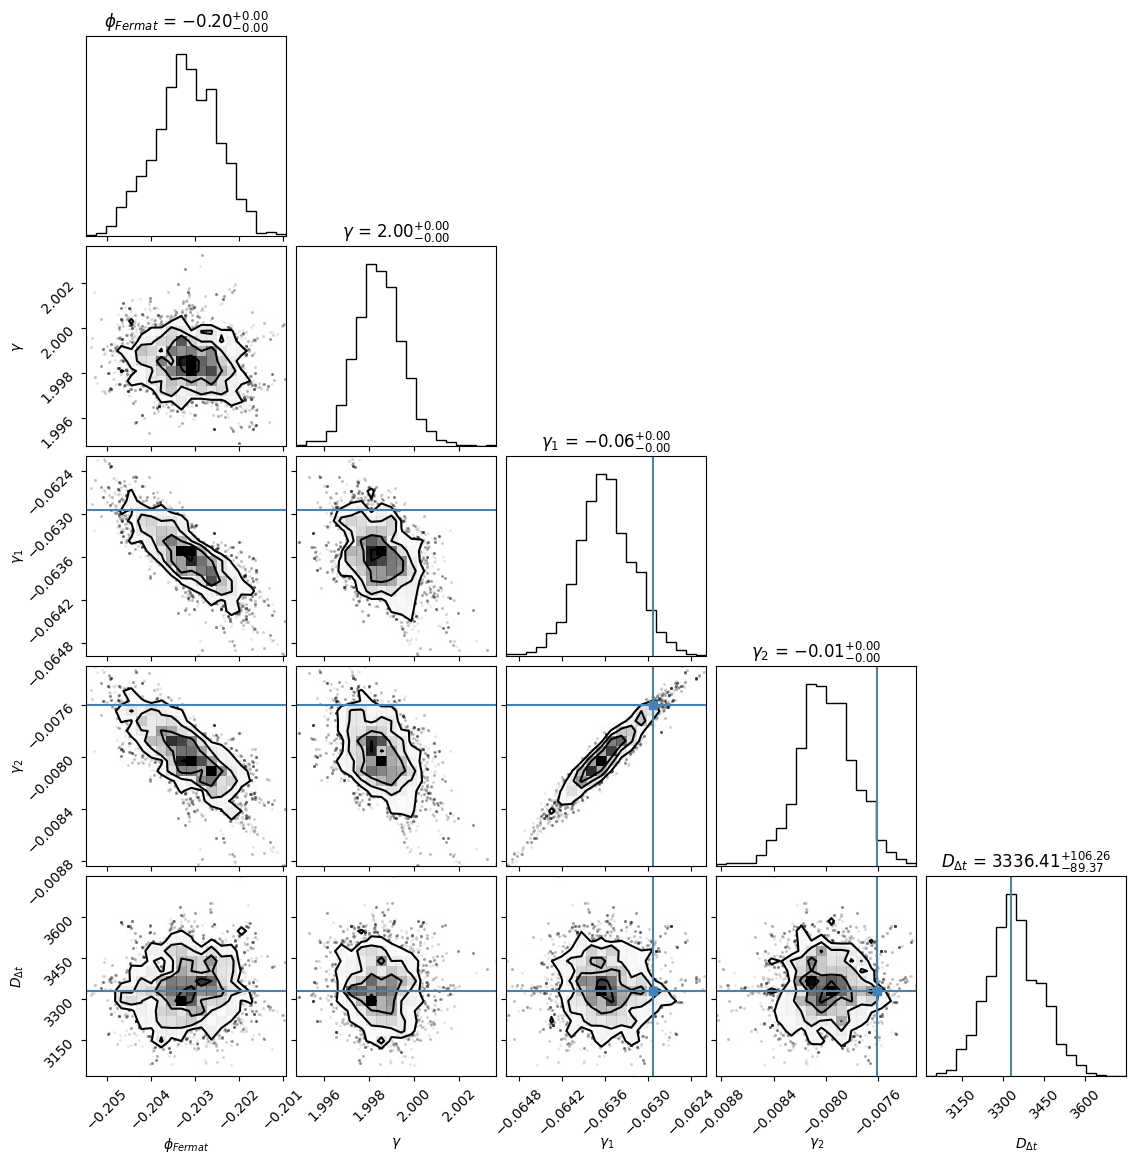

In [12]:
for i in range(len(chain_list)):
    chain_plot.plot_chain_list(chain_list, i)
    
sampler_type, samples_mcmc, param_mcmc, dist_mcmc  = chain_list[1]

print("number of non-linear parameters in the MCMC process: ", len(param_mcmc))
print("parameters in order: ", param_mcmc)
print("number of evaluations in the MCMC process: ", np.shape(samples_mcmc)[0])
import corner


# import the parameter handling class #
from lenstronomy.Sampling.parameters import Param
# make instance of parameter class with given model options, constraints and fixed parameters #

param = Param(kwargs_model, fixed_lens, fixed_source, fixed_lens_light, fixed_ps, fixed_cosmo, 
              kwargs_lens_init=kwargs_result['kwargs_lens'], **kwargs_constraints)
# the number of non-linear parameters and their names #
num_param, param_list = param.num_param()

from lenstronomy.Analysis.td_cosmography import TDCosmography
td_cosmo = TDCosmography(z_lens, z_source, kwargs_model, cosmo_fiducial=cosmo)

mcmc_new_list = []
labels_new = [r"$\phi_{Fermat}$", r"$\gamma$", r"$\gamma_1$", r"$\gamma_2$", r"$D_{\Delta t}$"]
for i in range(len(samples_mcmc)):
    # transform the parameter position of the MCMC chain in a lenstronomy convention with keyword arguments #
    kwargs_result = param.args2kwargs(samples_mcmc[i])
    D_dt = kwargs_result['kwargs_special']['D_dt']
    fermat_pot = td_cosmo.fermat_potential(kwargs_result['kwargs_lens'], kwargs_result['kwargs_ps'])
    delta_fermat_12 = fermat_pot[0] - fermat_pot[2]
    gamma = kwargs_result['kwargs_lens'][0]['gamma']
    gamma1, gamma2, = kwargs_result['kwargs_lens'][1]['gamma1'], kwargs_result['kwargs_lens'][1]['gamma2']
    mcmc_new_list.append([delta_fermat_12, gamma, gamma1, gamma2, D_dt])

from lenstronomy.Cosmo.lens_cosmo import LensCosmo
lensCosmo = LensCosmo(z_lens=z_lens, z_source=z_source, cosmo=cosmo)
Ddt_true = lensCosmo.ddt
truths=[np.nan, 1.95, gamma1, gamma2, Ddt_true]
plot = corner.corner(np.array(mcmc_new_list), labels=labels_new, show_titles=True, truths=truths)

In [13]:
print(lensCosmo.ddt)

3329.6653609254795
